<b> Income Classification Analysis

<u>Introduction</u>

This project leverages U.S Census data to analyze demographic and economic attributes, to predict whether an individual's income exceeds $50000 per annum. The dataset(learn + test) provided contain approximately 300,000 records with 42 attributes.

Project Overview

A classification pipeline has been developed that integrates the following:

1. Exploratory Data Analysis: Analyzed feature distributions, correlations, and trends to guide preprocessing decisions
2. Data Preparation: Addressed duplicates, label resolution as well as transformation of nominal and continuous features
3. Feature Engineering: Created additional features to enhance predictive performance of models utilised
4. Model Pipeline: Implemented Logistic Regression as benchmark model as well as XGBoost and LightGBM to achieve more predictive power
5. Evaluation: Compared models using precision, recall, F1 score and AUC-ROC metrics to select the best performer 

In [1]:
import warnings
warnings.filterwarnings("ignore")

from data_loader import DataLoader
from data_cleaner import DataCleaner
from eda import EDA
from feature_engineer import FeatureEngineer
from model_trainer import ModelTrainer

In [3]:
loader = DataLoader(
        metadata_path='census_income_metadata.txt', 
        learn_path='census_income_learn.csv',
        test_path='census_income_test.csv')
loader.load_metadata()
learn_df, test_df = loader.load_dataframes()
print(f"learn_df.shape: {learn_df.shape}, test_df.shape: {test_df.shape}")


learn_df.shape: (199523, 42), test_df.shape: (99762, 42)


In [5]:
cleaner = DataCleaner(learn_df, test_df)

The columns printed below are all removed as they are missing in roughly 49% of the data. Any kind of imputation on these columns will most likely be harmful to the true nature of their relationship with the target label as well as the rest of the feature set.

In [6]:
missing_cols = cleaner.drop_high_missing_cols()
missing_cols

Column  Missing Count  Missing Percentage
0    migration code-change in msa         149642           49.999833
1    migration code-change in reg         149642           49.999833
2  migration code-move within reg         149642           49.999833
3   migration prev res in sunbelt         149642           49.999833

The rest of the columns are first label encoded and then KNN imputation is performed. KNNimputer works solely with numerical data, hence it's important to encode the data before. The data is then inverse transformed to revert the encoding for further EDA.

The reason KNN Imputation was chosen is because it makes no assumptions about the distribution of data and is ideal for a dataset with a blend of categorical and continuous features that may have linear or non-linear relationships (to be explored in this analysis).

In [7]:
cleaner.encode_and_impute()

In [8]:
cleaner.check_duplicates(drop_target_weight=True)

Duplicates in learn: 47244, Duplicates in test: 21423


The duplicates reported in metadata file are based solely on features excluding instance weight and the target variable, total person income.  There are 2 types of redundancy in this data;  while the second is duplicate feature set with conflicting labels. The following steps were taken to resolve both cases:

1. Duplicate Feature Set & Target: These are resolved by dropping the duplicates whilst summing up the instance weights to avoid under-representing that group in the dataset
2. Duplicate Feature Set With Conflicting Labels: These are resolved by using weighted majority voting which sums up the instance weight for each target class within a group. The target label with the highest combined weight is used as the resolved label.

In [9]:
cleaner.remove_duplicates_and_resolve_labels()

In [10]:
cleaner.check_duplicates()

Duplicates in learn: 0, Duplicates in test: 0


In [11]:
learn_cleaned = cleaner.learn_df.copy()
test_cleaned = cleaner.test_df.copy()

In [12]:
eda_obj = EDA(learn_cleaned, test_cleaned)

In [13]:
continuous_cols = [
        "age", "wage per hour", "capital gains", "capital losses", 
        "dividends from stocks", "num persons worked for employer", 
        "weeks worked in year", "instance weight"]

                      Count  Percentage
total_person_income                    
-50000               140030   91.902499
 50000                12338    8.097501


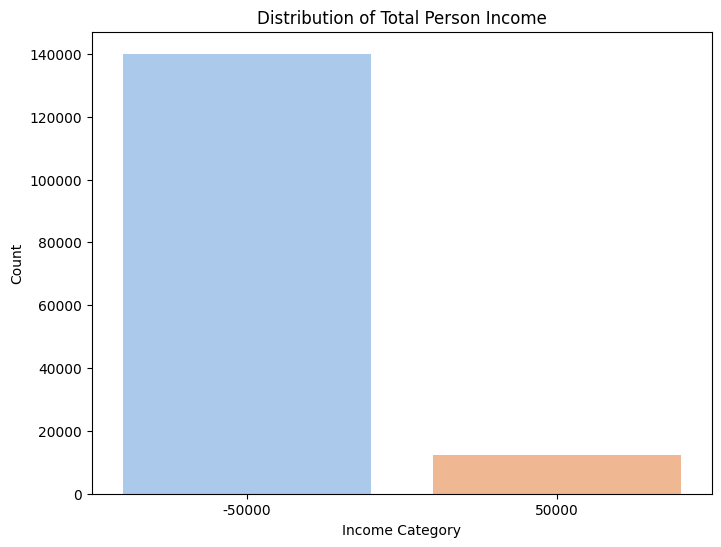

In [14]:
eda_obj.fix_target_income_column()
eda_obj.distribution_of_target()

As shown from the above plot, the target is heavily imbalanced with nearly 92% of individuals not earning more than $50,000. The class imbalance needs to be addressed so that classification models capture minority class patterns through methods like over/under sampling and stratified splits during model training. 

In [15]:
eda_obj.eda_continuous_cols(continuous_cols)


age  wage per hour  capital gains  capital losses  \
count  152368.000000  152368.000000  152368.000000   152368.000000   
mean       39.834887      72.574904     569.202759       48.833108   
std        19.595978     312.583602    5368.378091      310.033920   
min         0.000000       0.000000       0.000000        0.000000   
25%        26.000000       0.000000       0.000000        0.000000   
50%        38.000000       0.000000       0.000000        0.000000   
75%        53.000000       0.000000       0.000000        0.000000   
max        90.000000    9999.000000   99999.000000     4608.000000   

       dividends from stocks  num persons worked for employer  \
count          152368.000000                    152368.000000   
mean              257.909902                         2.546847   
std              2265.269433                         2.403426   
min                 0.000000                         0.000000   
25%                 0.000000                         0.000000   
50%                 0.000000                         2.000000   
75%                 0.000000                         5.000000   
max             99999.000000                         6.000000   

       weeks worked in year  instance weight  
count         152368.000000    152368.000000  
mean              30.165763      2278.994884  
std               23.761616     12085.736315  
min                0.000000        37.870000  
25%                0.000000      1077.960000  
50%               46.000000      1660.400000  
75%               52.000000      2317.050000  
max               52.000000    730368.000000

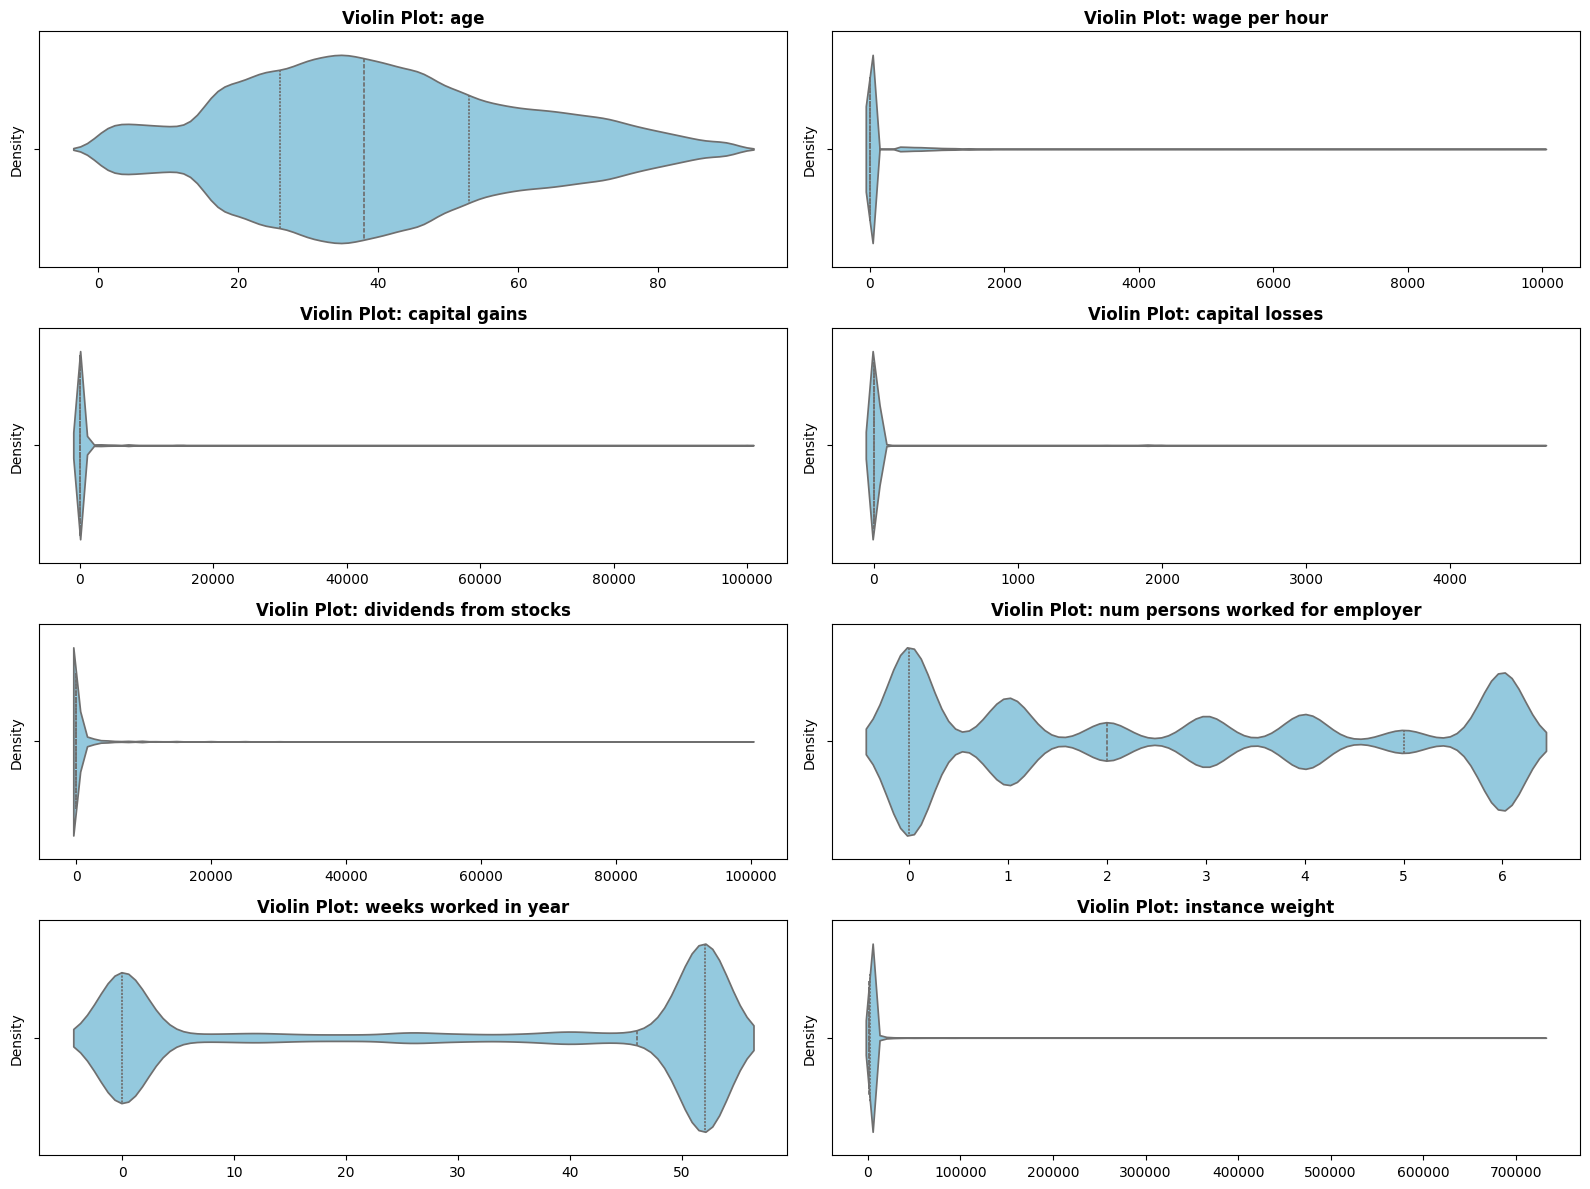

In [16]:
eda_obj.violin_plots(continuous_cols)

Some noteworthy insights from the descriptive statistics:
1. The mean wage per hour is 72.32, but the maximum is 9,999. This could potentially indicate outliers or data entry errors.
2. Similar to mean wage per hour, capital gains and capital losses and dividend from stocks also show extreme values in their max; the distributions are skewed in this data. 
3. Max number of persons worked for employer is 6 and mean is 2.54. This is relatively low suggesting that most people work for smaller companies.
4. Roughly 25% people worked 0 weeks indicating unemployed people such as children or unemployed adults.
5. Capital gains, losses and dividends are all 0 in the 25th, 50th and 75th percentile; this indicates that very few people report gains, losses, dividends. 


Insights from the violin plots:
1. Age is ever so slightly skewed towards younger ages, but is overall a well-distributed feature for modelling
2. Wage per hour, capital gains, capital losses and dividends from stocks are highly right skewed with most values concentrated at 0. This confirms the need to transform these values to prevent bias in the model
3. Number of persons working for employer has distinct peaks at 0, 1, 2, 3, 4, 5 and 6. It's possible this is more of a categorical variable than a numeric one or that contrary to the previous assumption that there's only small businesses being analysed (in descriptive statistics)
4. Weeks worked in a year implies clear groups of non-workers/unemployed workers and full-time workers, which may influence income 

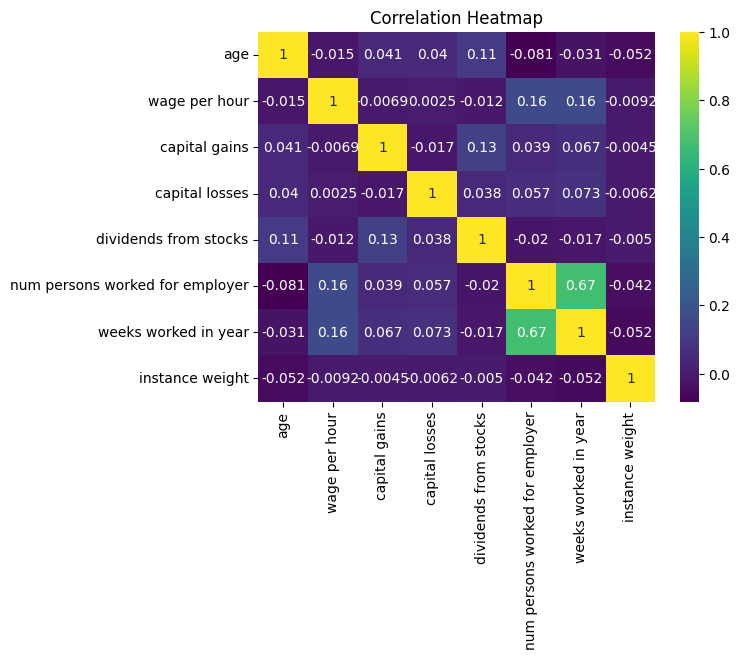

In [17]:
eda_obj.correlation_heatmap(continuous_cols)

Most features from the above correlation heatmap have correlations near 0, indicating negligble <b> linear </b> relationship. There are some key observations to take into account:
1. <b> num persons worked for employer vs weeks worked in a year </b> shows a moderately strong positive correlation, which makes sense as people working more weeks likely work for more employers or teams.
2. <b> capital gains vs dividend from stocks </b> shows a small tendency of people to make the capital gains through dividends from the stocks they own.
3. <b> instance weight </b> has negligible correlation with all other variables; it's not useful for prediction (as highlighted in metadata file) 
4. Many features have extreme values or act categorical in nature thus limiting linear relationship

To get a better sense of how each continuous feature may interact with each other, the following pairplot is helpful:

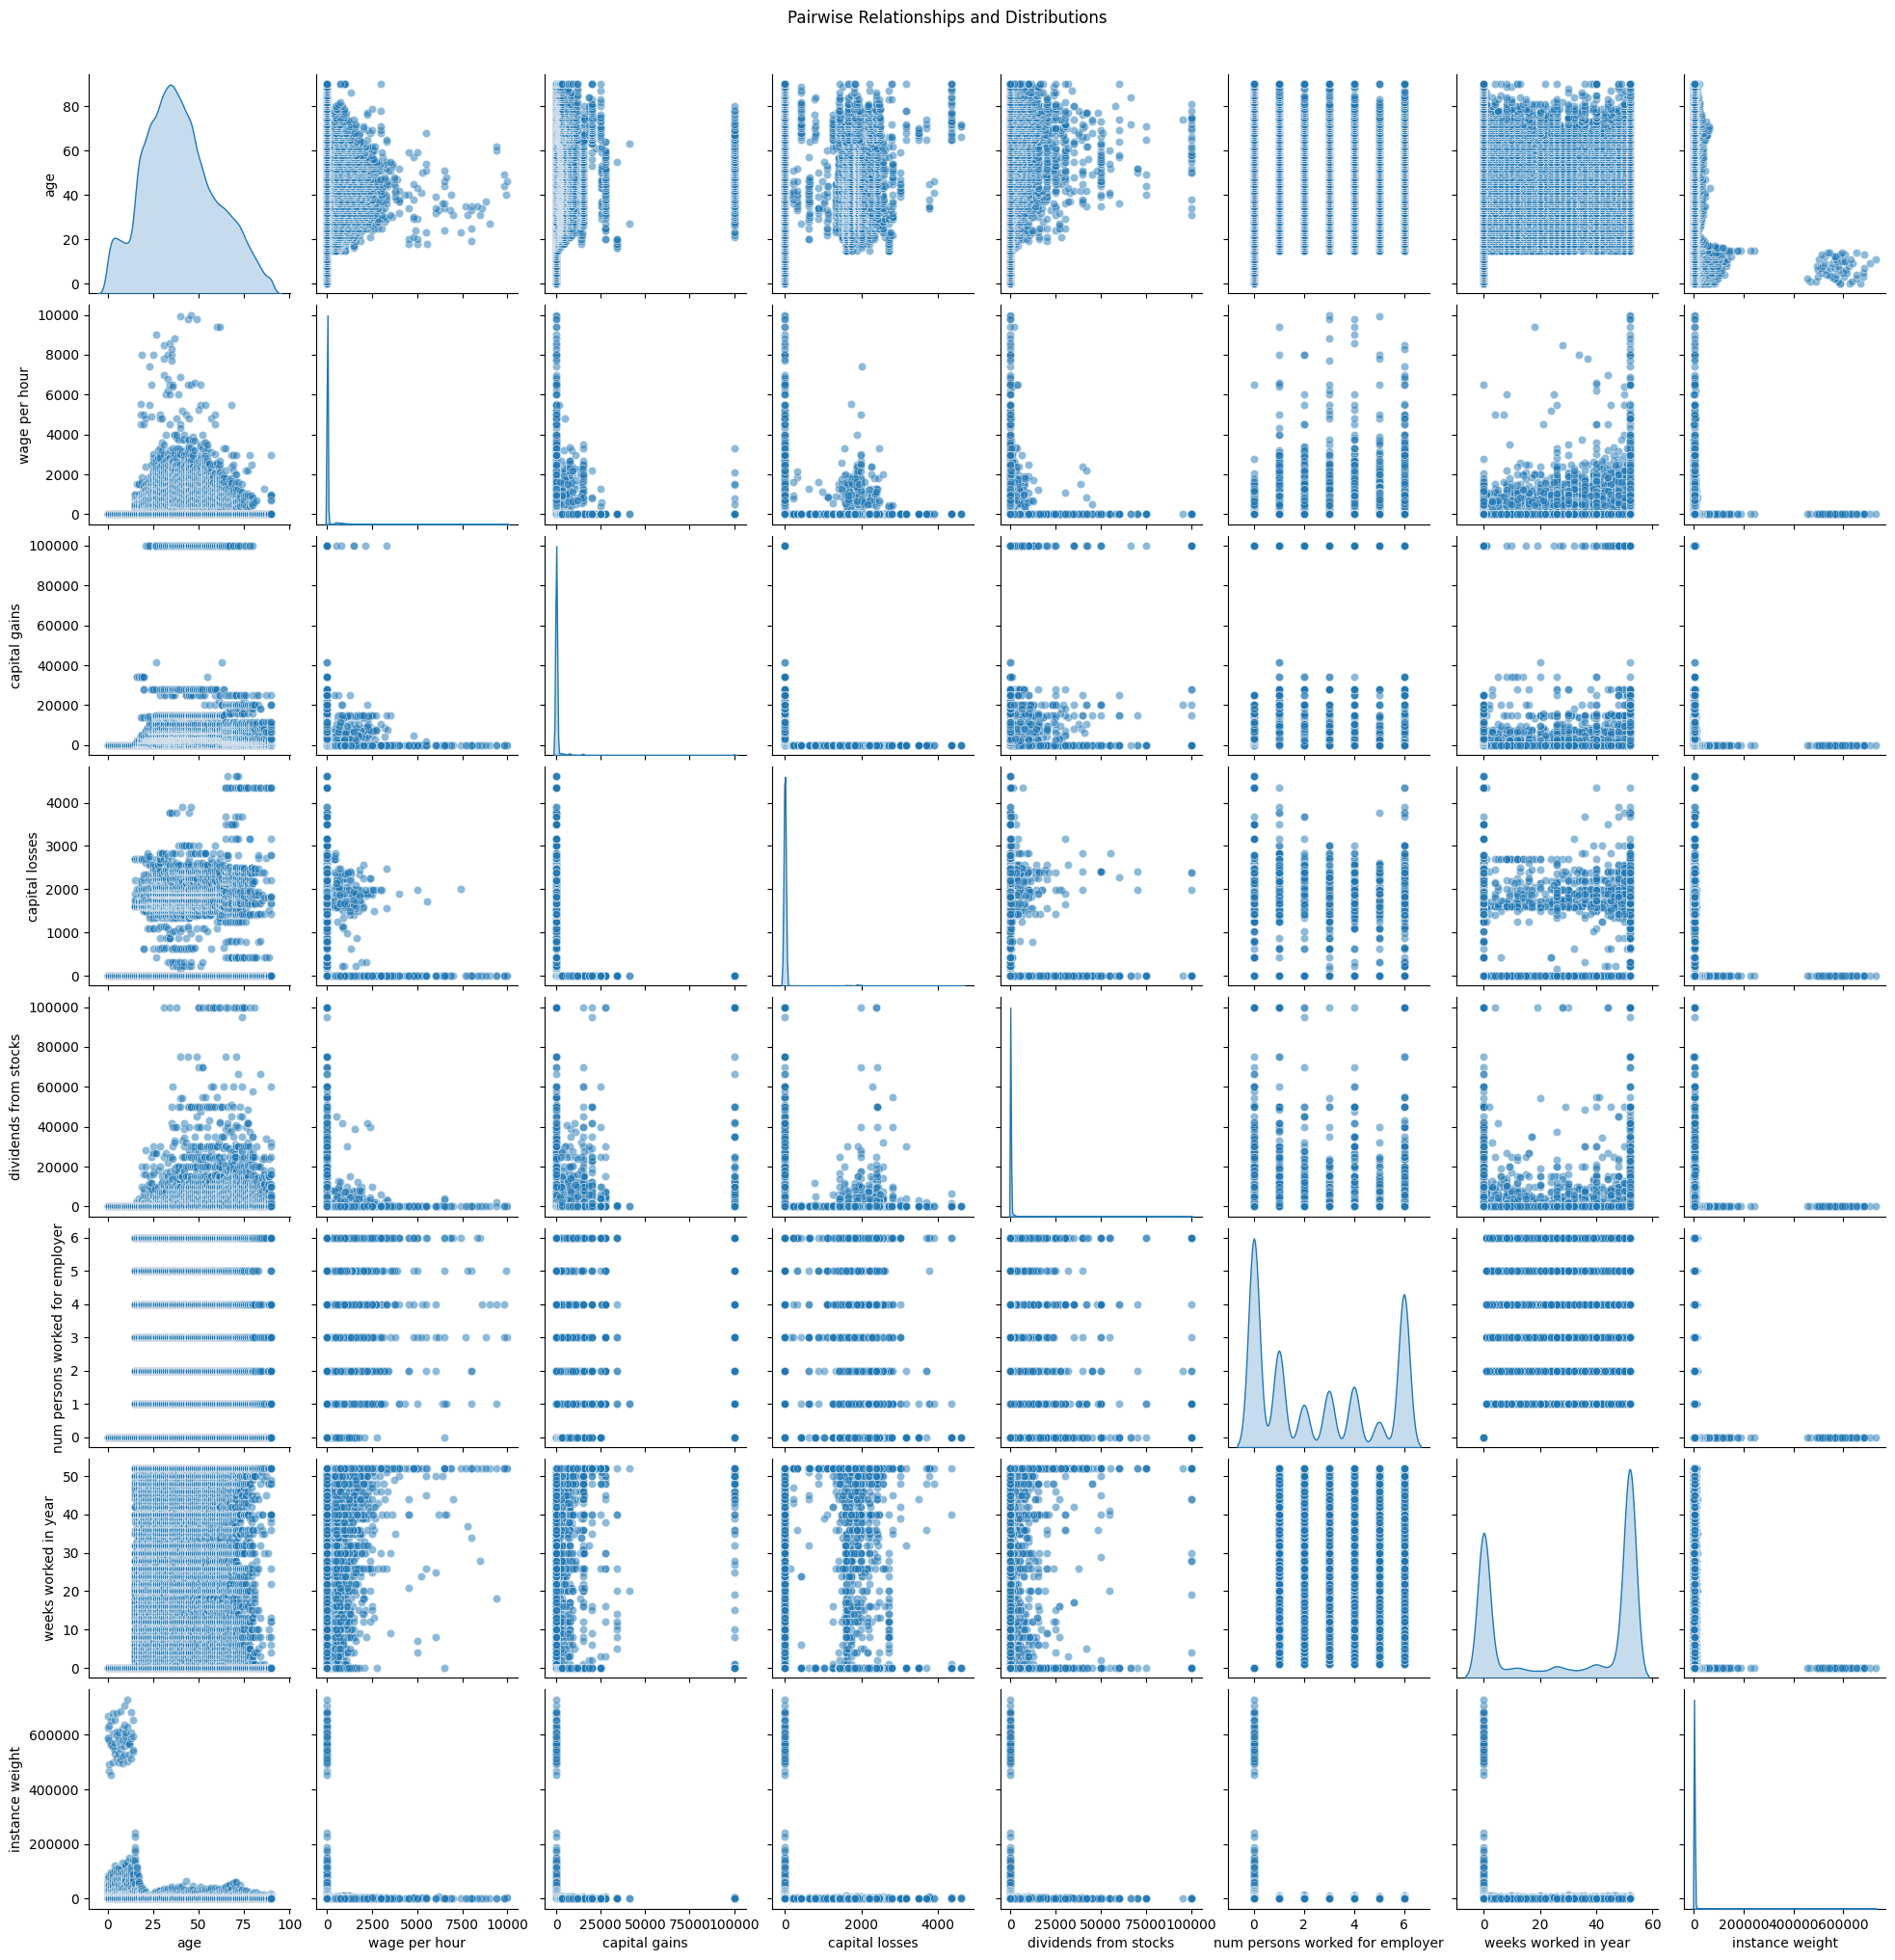

In [18]:
eda_obj.pairwise_relationship(continuous_cols)

<b> Insights from the pairplot: </b>

1. Most scatter plots show dense clusters at 0 indicating sparsity in the data and very few large values. 
2. Sparse, skewed and outlier-prone features dominate the continuous features of this dataset
3. Weeks worked in a year vs num persons worked for employer forms distinct clusters in the scatter plot, which could be engineered using K-means clustering to group the population
4. Sparse features like capital gains, capital losses could be converted to binary indicators to capture their impact and effect on predictions better
5. The age vs wage per hour scatter plot shows that higher wages are concentrated in older age groups but that's also a very small population; younger people earn less than older people. Interaction terms could be used here to better the predictions

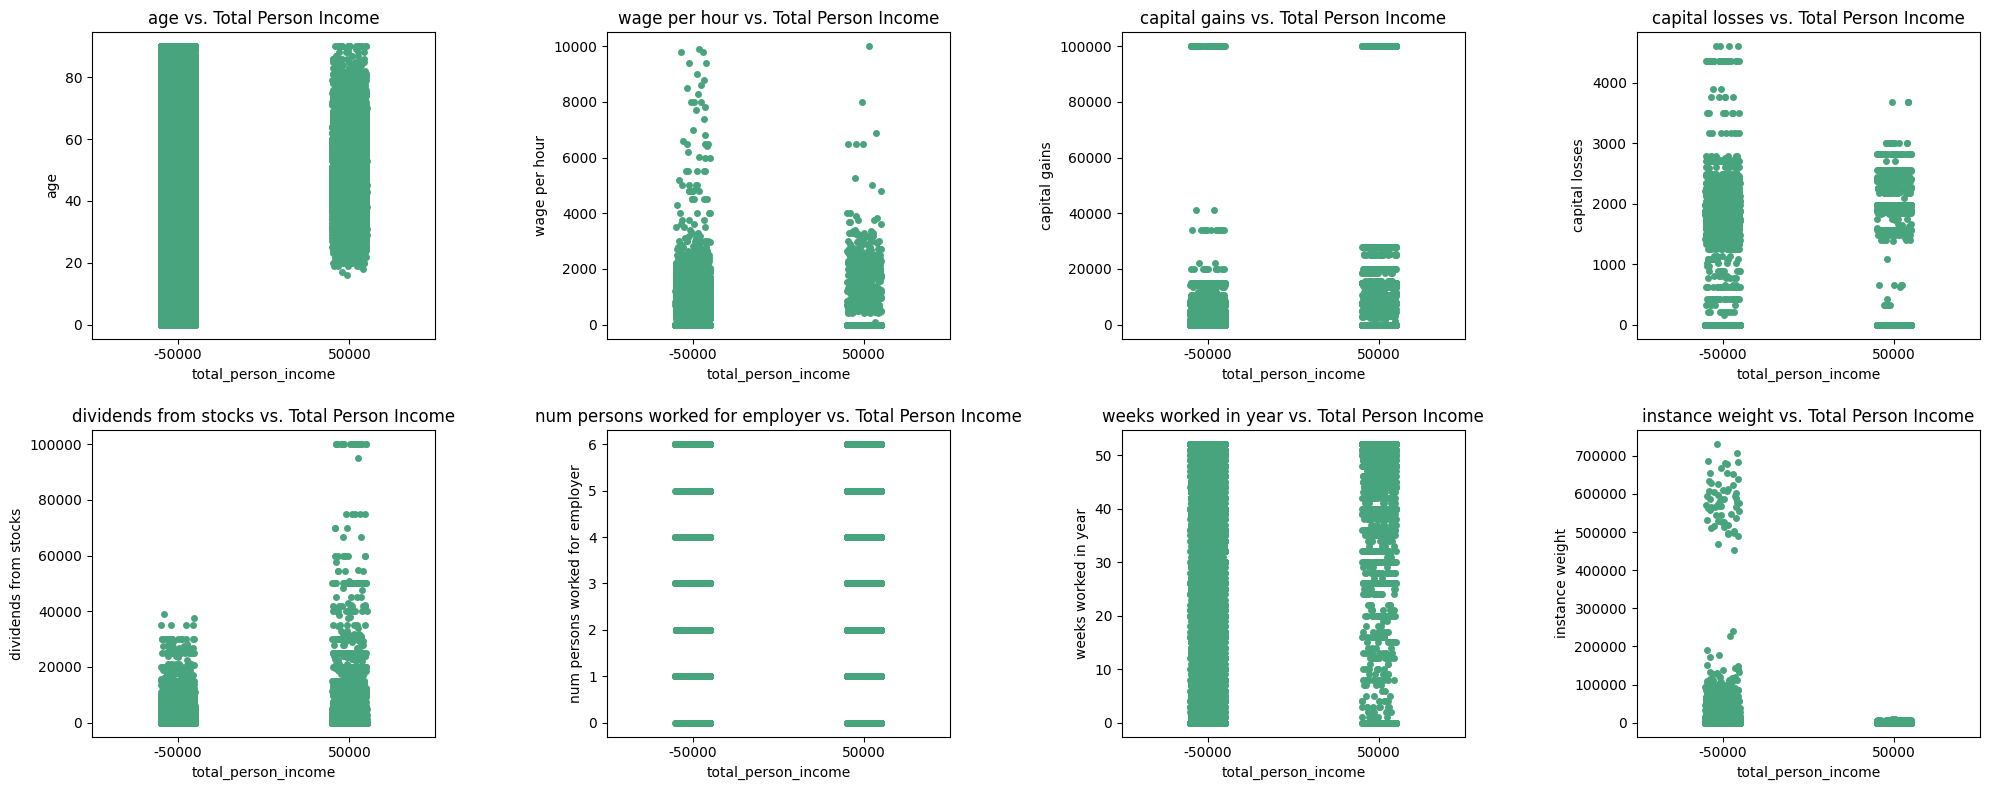

In [19]:
eda_obj.strip_plots_vs_target(continuous_cols)

The above strip plots show information regarding how each continuous feature reacts with the target. Key insights to note:

1. Higher capital gains and dividends are strongly associated with higher income while many values being 0 confirm previously statements of most people not having any of the two
2. Distribution for number of persons worked for employer vs target is fairly uniform across both income classes
3. People under the age of roughly 18-20 are solely in lower income class implying no income, as they're kids 

The above features show clear separation between income group making them important for the classification task. However, there is more clarification required on features like "num persons worked for employer vs Target" since it seems categorical and "weeks worked in year vs Target" as there is quite some overlap in data points. This could be better explained by split histograms:

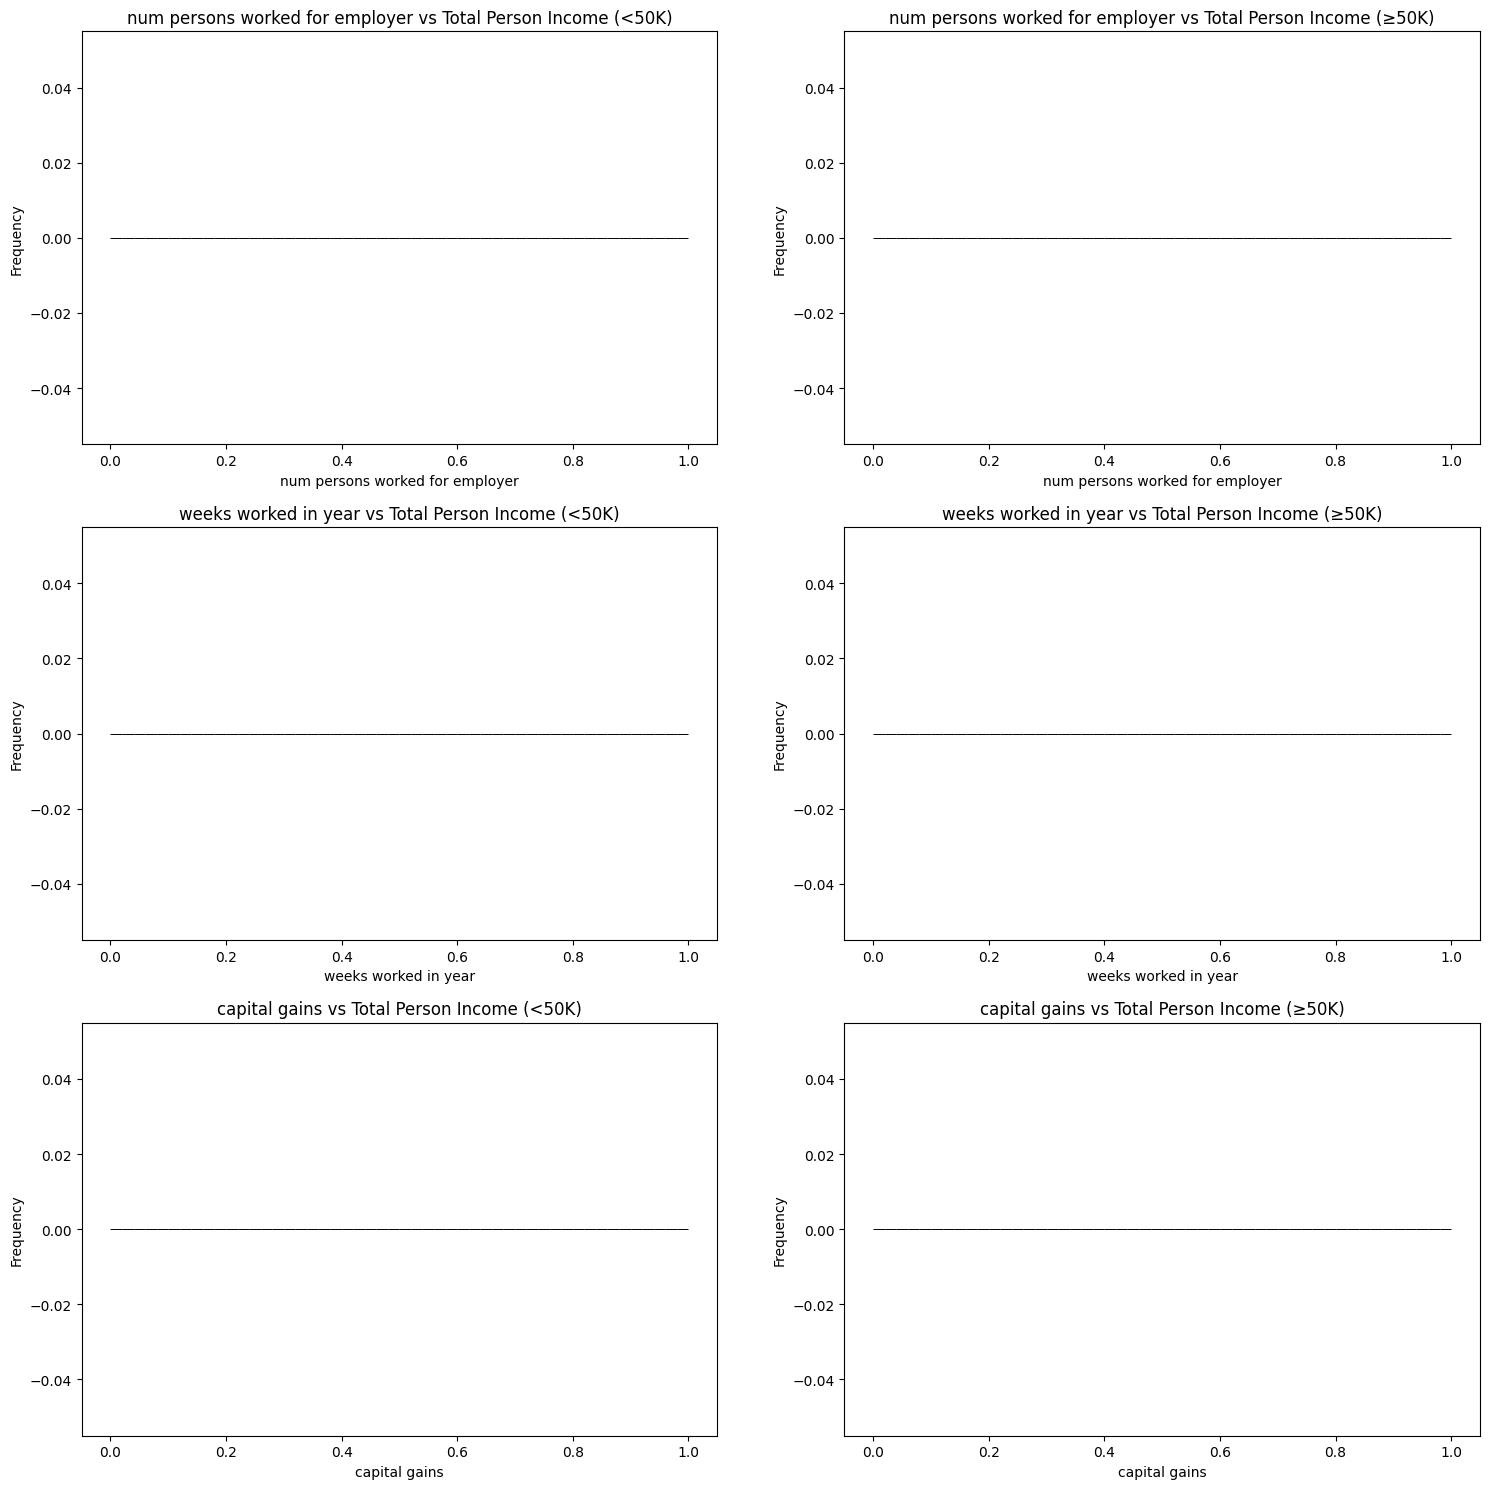

In [20]:
eda_obj.split_hist_plots(['num persons worked for employer', 'weeks worked in year', 'capital gains'])

<b> Statistical Significance of Continuous Features </b>

Since the correlation matrix showed weak correlations and proved negligble linear dependence amongst features, a non-parametric test like Mann-Whitney seems more appropriate here. This test helps in understanding whether the distributions of continuous features differ significantly between the two income groups without assuming normality of the data, ideal for data with skewed and sparse features.

The p values of the test confirms that all featrures are relevant for modelling income classifications except instance weight.



In [21]:
eda_obj.mannwhitney(continuous_cols)

age: Mann-Whitney U test statistic = 632994574.0000, p-value = 0.0000
wage per hour: Mann-Whitney U test statistic = 889311631.5000, p-value = 0.0000
capital gains: Mann-Whitney U test statistic = 720648898.5000, p-value = 0.0000
capital losses: Mann-Whitney U test statistic = 798238403.5000, p-value = 0.0000
dividends from stocks: Mann-Whitney U test statistic = 581172606.5000, p-value = 0.0000
num persons worked for employer: Mann-Whitney U test statistic = 525579423.0000, p-value = 0.0000
weeks worked in year: Mann-Whitney U test statistic = 468239840.5000, p-value = 0.0000
instance weight: Mann-Whitney U test statistic = 860800585.0000, p-value = 0.5157


<b> Statistical Significance & Magnitude of Association of Nominal Features

Similar to the continuous features, it's useful to check whether total person income is influenced by nominal features. The Current Population Survey 2019 Annual Social and Economic (ASEC) Supplement ("census_income_additional_info.pdf") emphasizes the use of Chi-Square tests to determine whether categorical variables are related. Additionally, it highlights the importance of confidence intervals and standard errors to assess the reliability of relationships which aligns with my check the strength of association between the total person income and each nominal feature.

In [22]:
nominal_cols = [col for col in learn_cleaned.columns if col not in continuous_cols and col not in ['total_person_income']]
stat_results = eda_obj.nominal_feature_analysis(nominal_cols)
stat_results

Column   Chi2_p_value  Cramer's V
0                   detailed occupation recode   0.000000e+00    0.420670
1                                    education   0.000000e+00    0.372053
2                        major occupation code   0.000000e+00    0.343685
3                     detailed industry recode   0.000000e+00    0.261353
4                          major industry code   0.000000e+00    0.243796
5                              class of worker   0.000000e+00    0.224223
6           detailed household and family stat   0.000000e+00    0.211166
7                               tax filer stat   0.000000e+00    0.197602
8      detailed household summary in household   0.000000e+00    0.196620
9                                          sex   0.000000e+00    0.178720
10                                marital stat   0.000000e+00    0.167876
11           full or part time employment stat   0.000000e+00    0.134836
12                     family members under 18   0.000000e+00    0.106469
13                             hispanic origin  2.619924e-259    0.089879
14                           veterans benefits  5.854779e-259    0.088345
15                     country of birth father  3.129098e-207    0.085716
16                     country of birth mother  1.144196e-202    0.084878
17                  enroll in edu inst last wk  6.831420e-205    0.078554
18               own business or self employed  2.100828e-168    0.071189
19                       country of birth self  8.920513e-134    0.070907
20                                        race  6.715003e-156    0.069046
21                                 citizenship   2.753417e-95    0.054120
22                     member of a labor union   3.187371e-88    0.051425
23                 state of previous residence   1.479941e-55    0.051055
24                region of previous residence   5.894915e-75    0.048394
25               live in this house 1 year ago   2.477952e-76    0.047803
26                     reason for unemployment   1.845383e-53    0.041059
27  fill inc questionnaire for veteran's admin   1.720668e-16    0.021828
28                                        year   5.465776e-17    0.021459

From the above results, it can be seen that:

1. Detailed Occupation recode and education have the highest Cramer's V values. Major occupation code and detailed industry recode also show moderate-to-strong associations reflecting that job-related variables have an higher impact on income than the rest 
2. Class of worker, household and family stats and tax filer status indicate moderate predictive power. This could have an impact on economic stability and income of the family members
3. State of previous residence, year,, reason for unemployment have extremely low association and should be discarded

As all the features have low chi squared p values, their Cramer's V value becomes more important in removing noisy features or ones that won't have much positive impact on model performance unless they're combined with other features. The shortlisted columns distributions have been analysed below.

<b> Distribution of Nominal Features

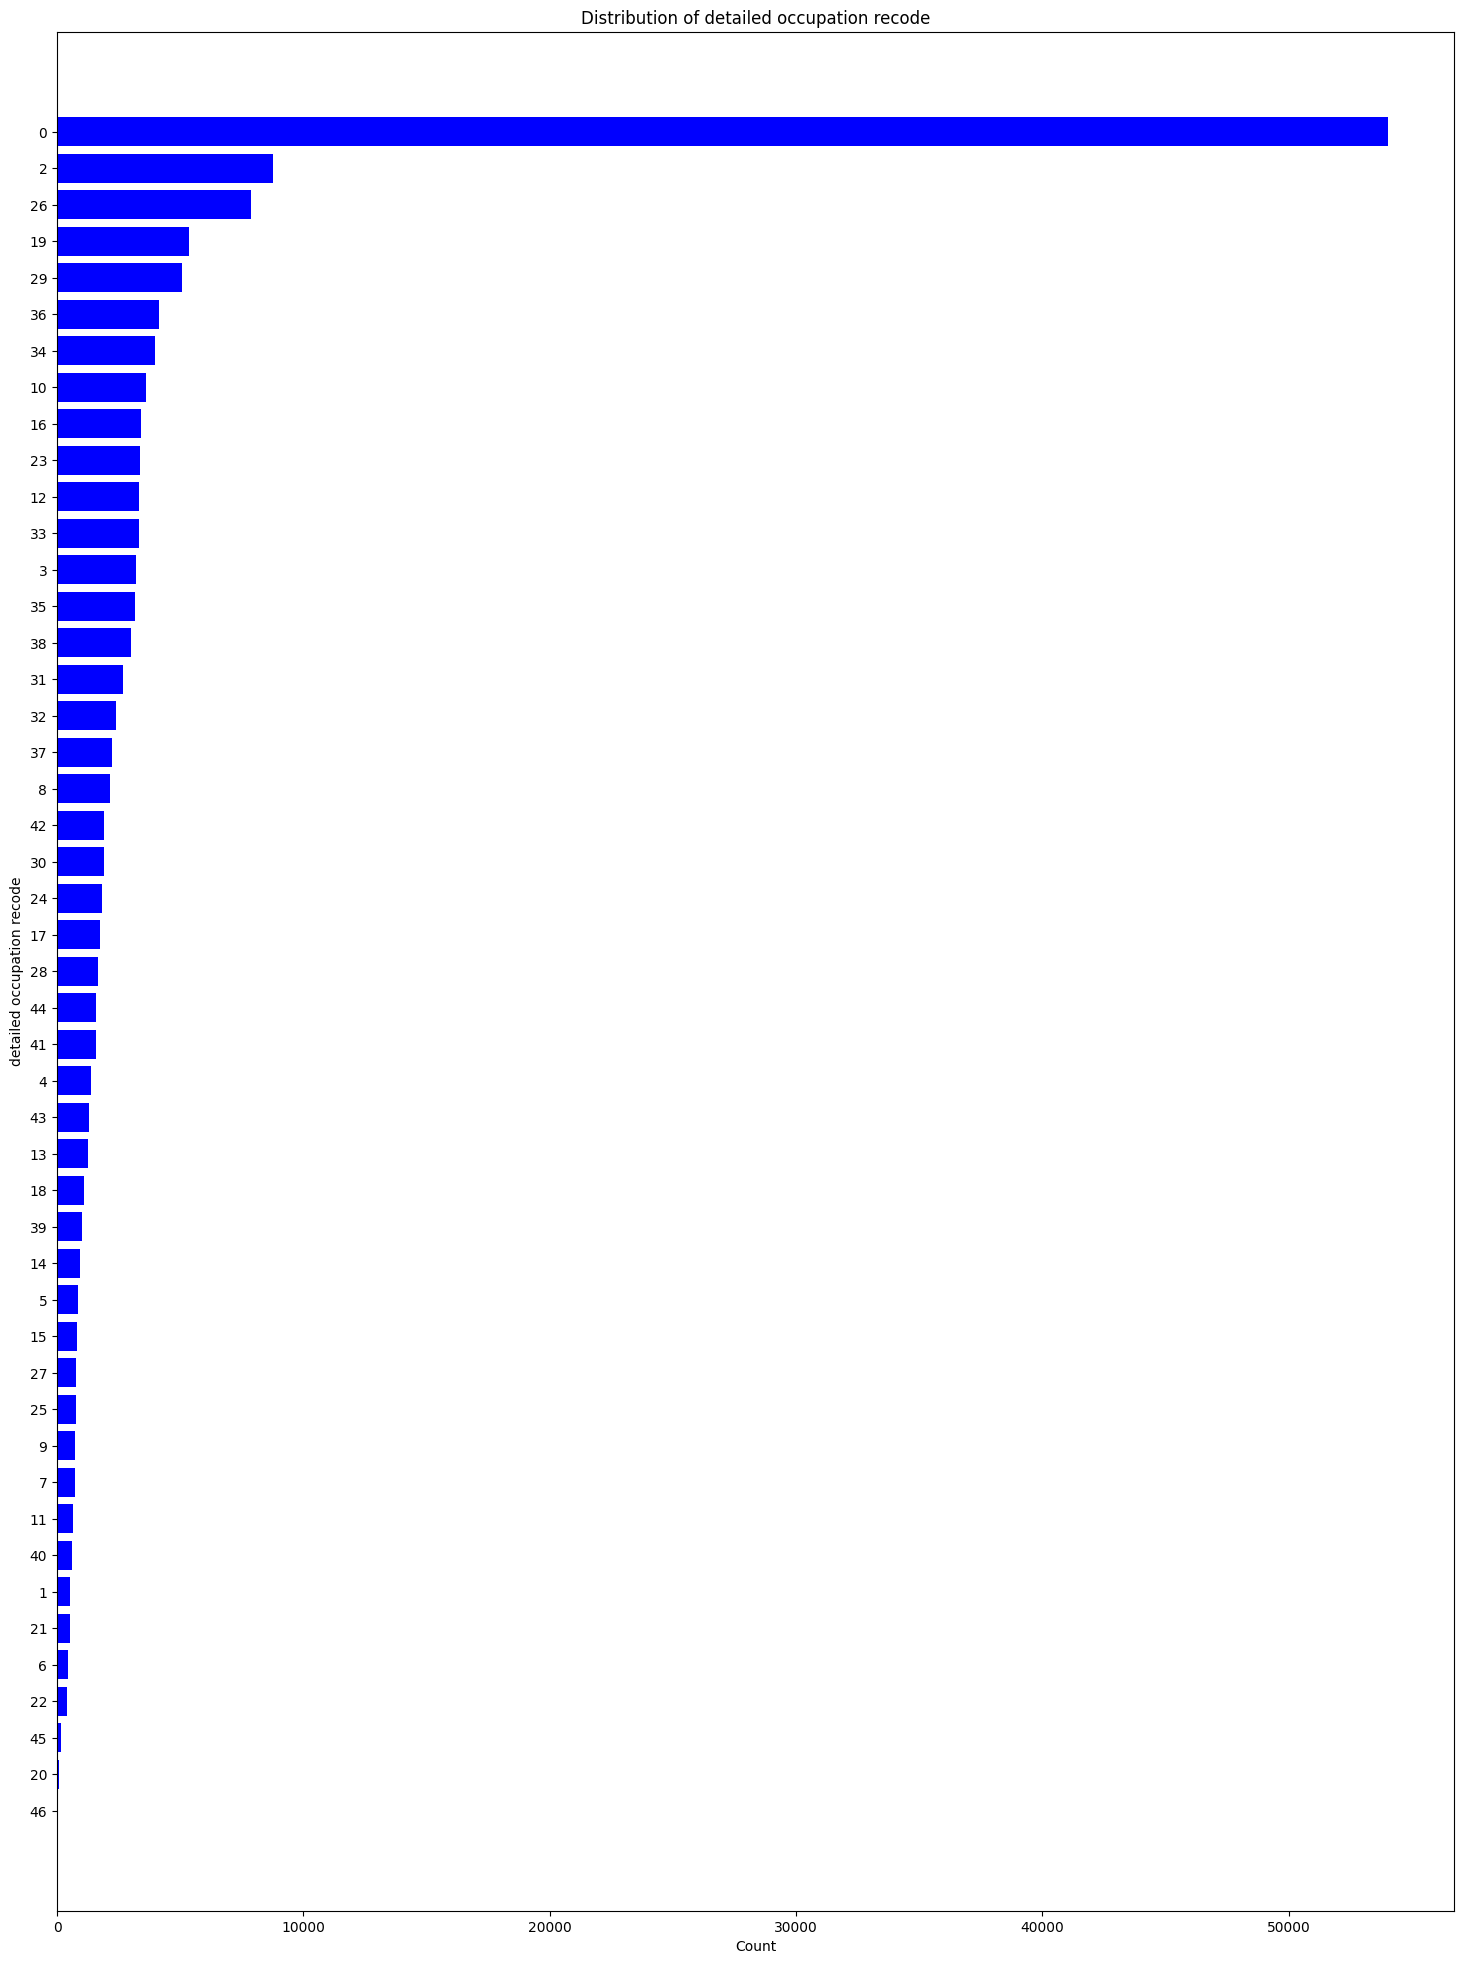

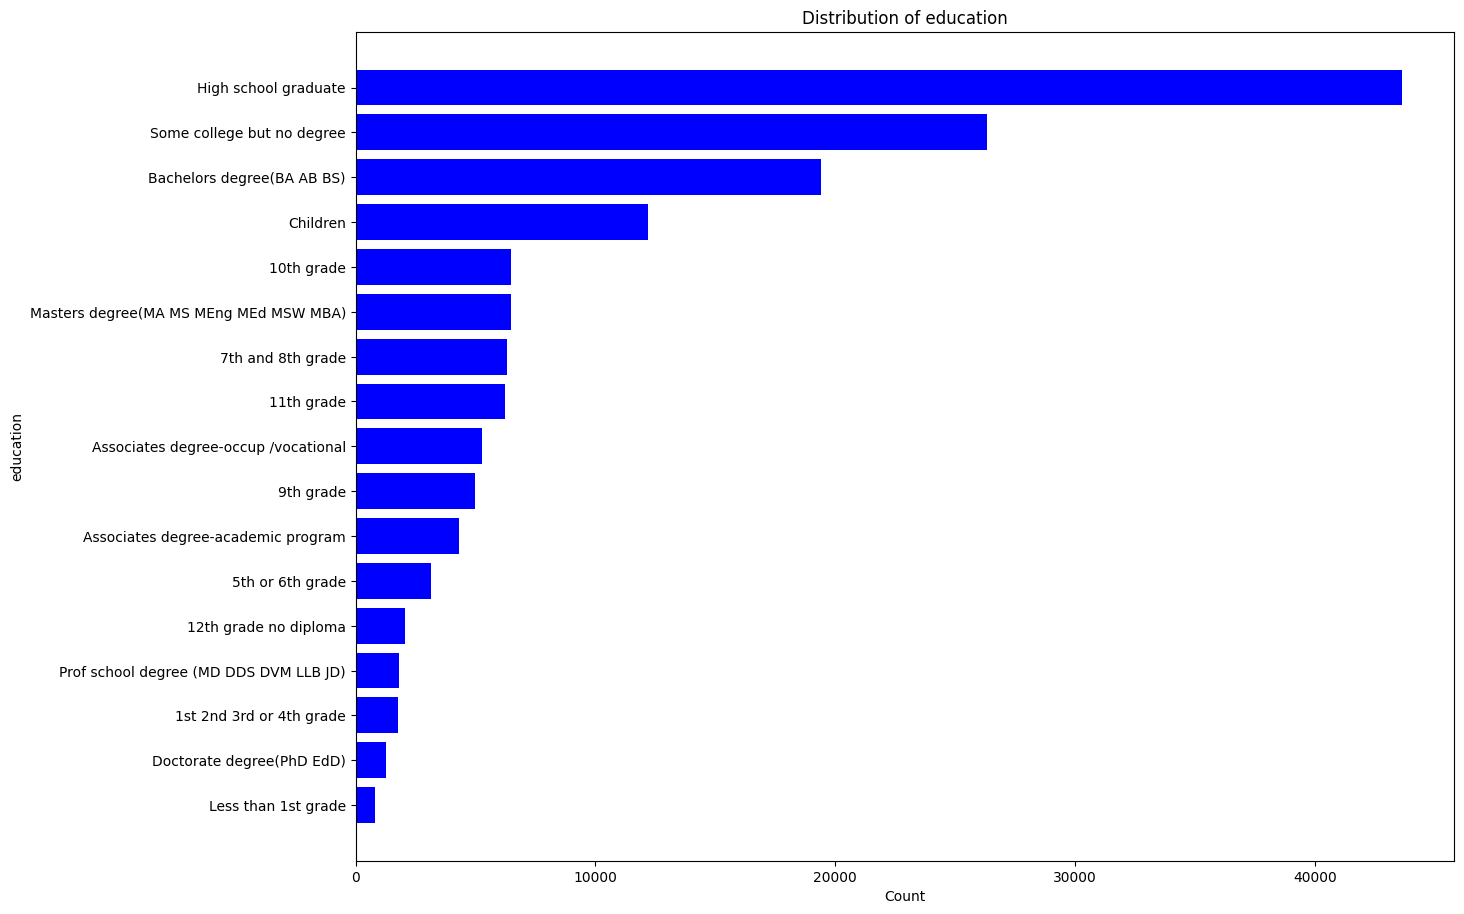

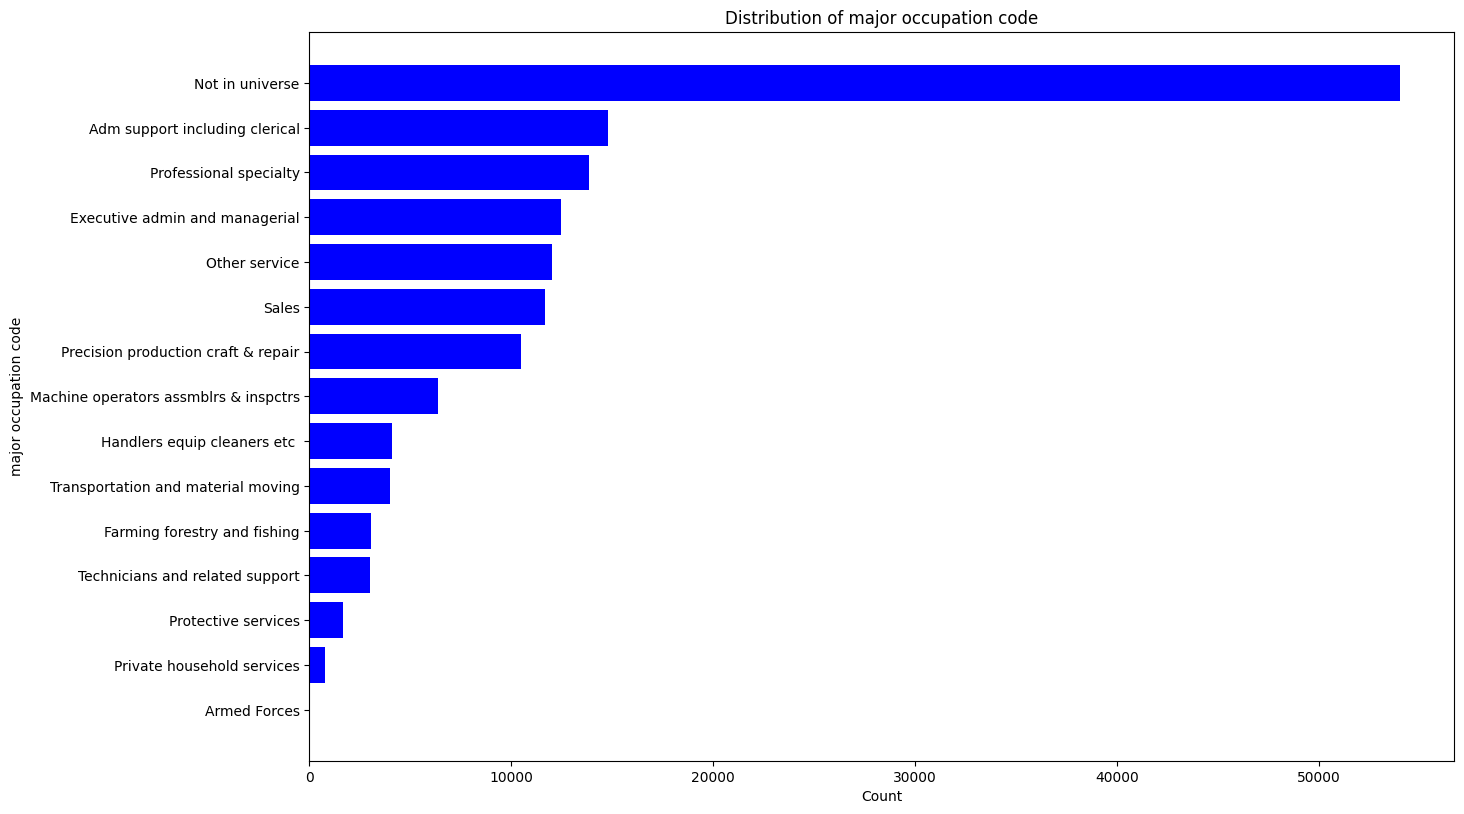

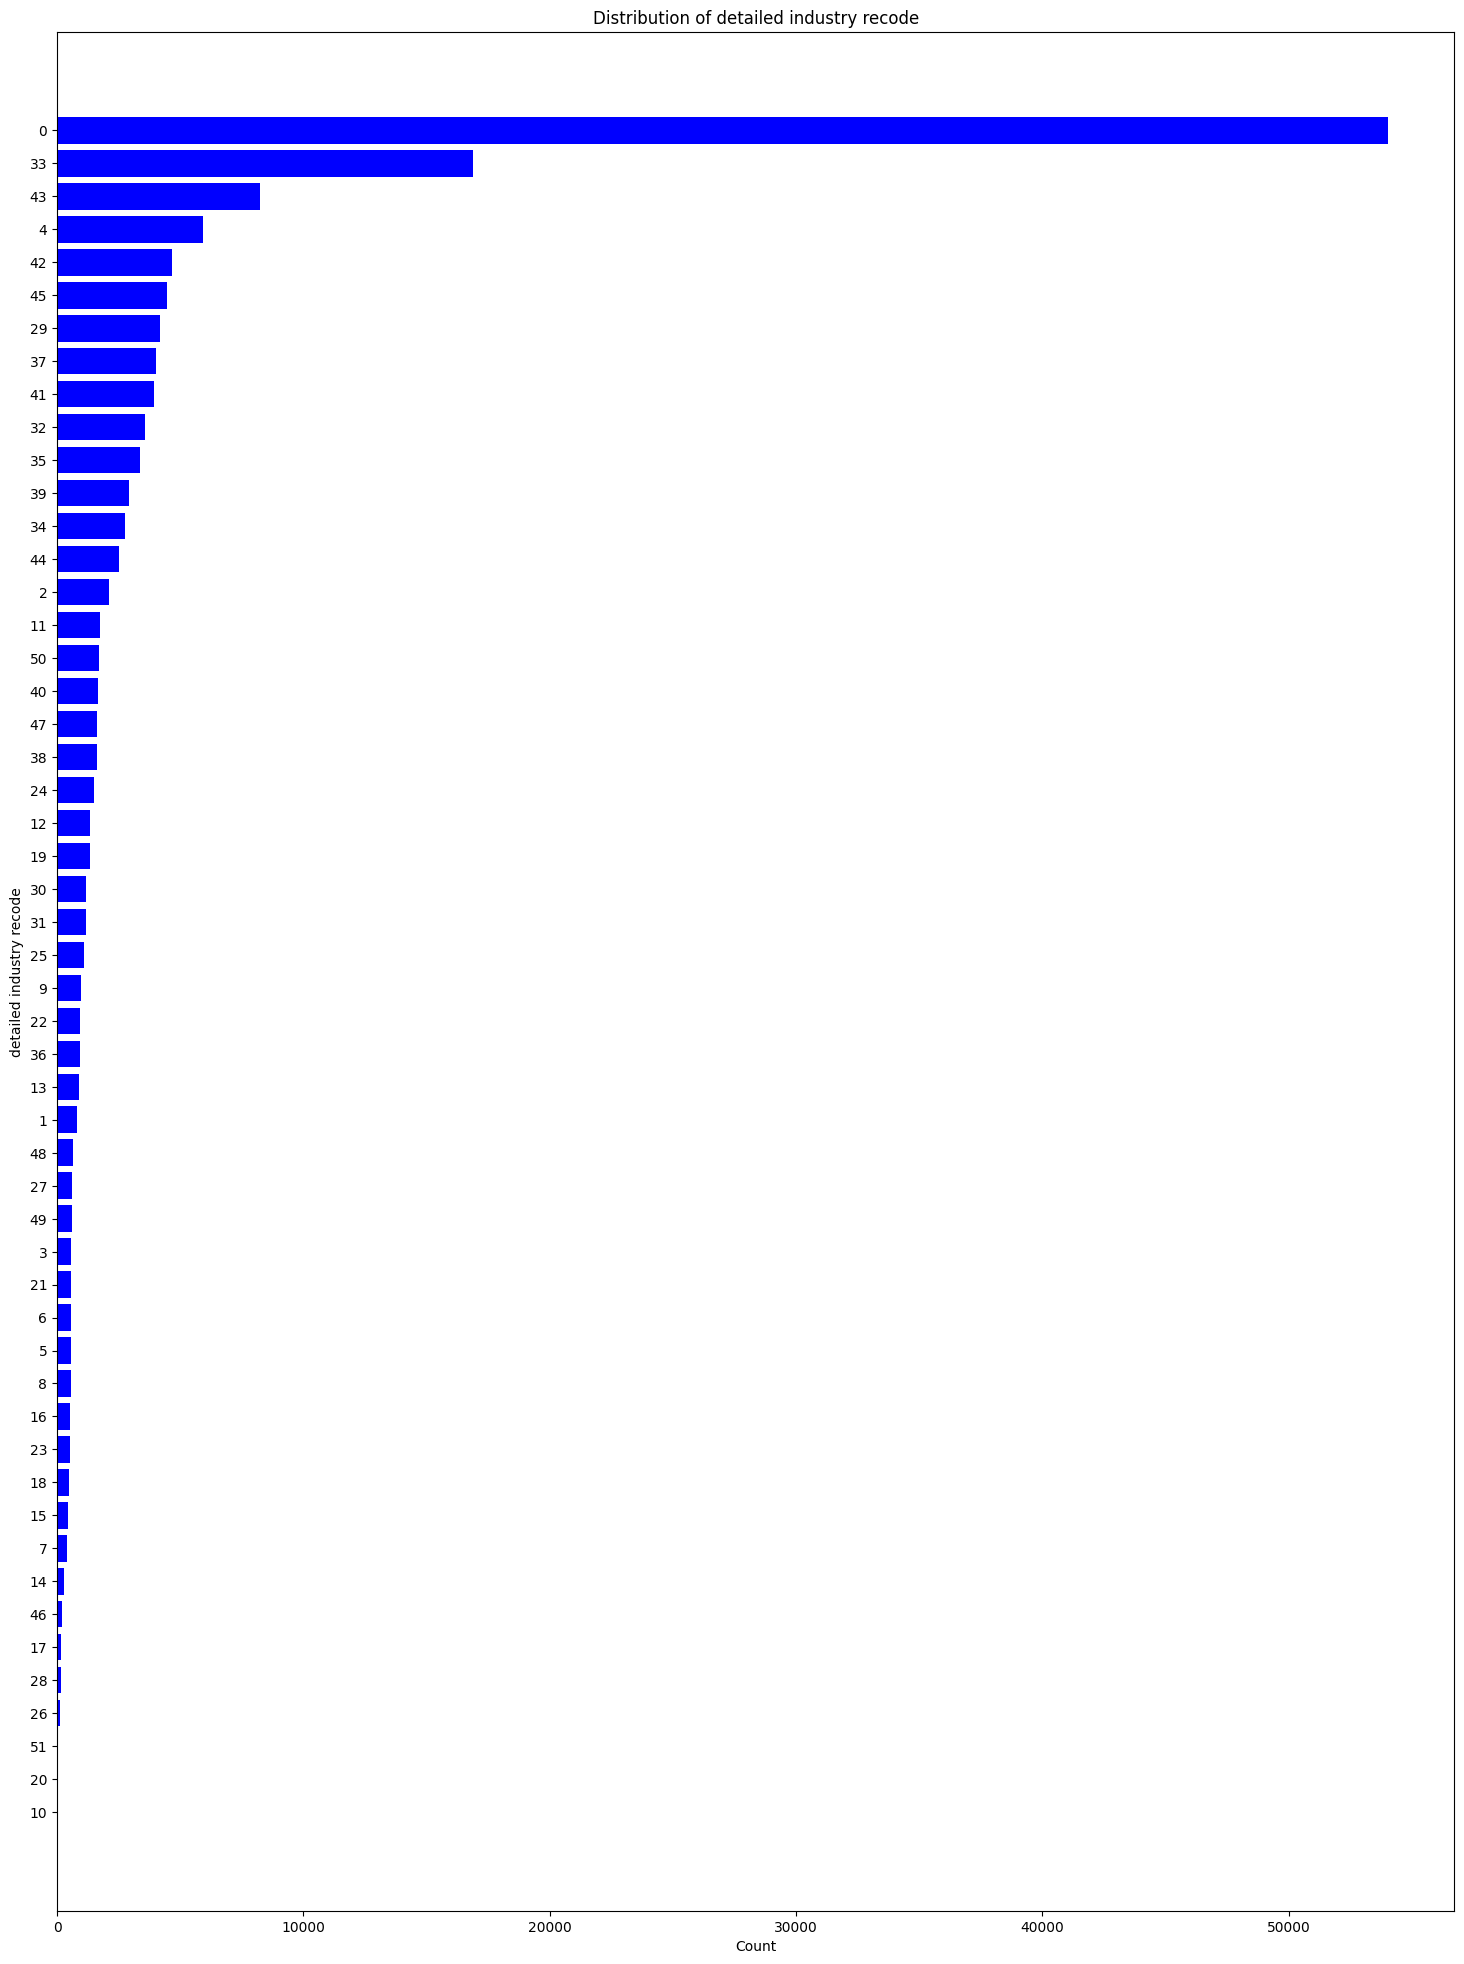

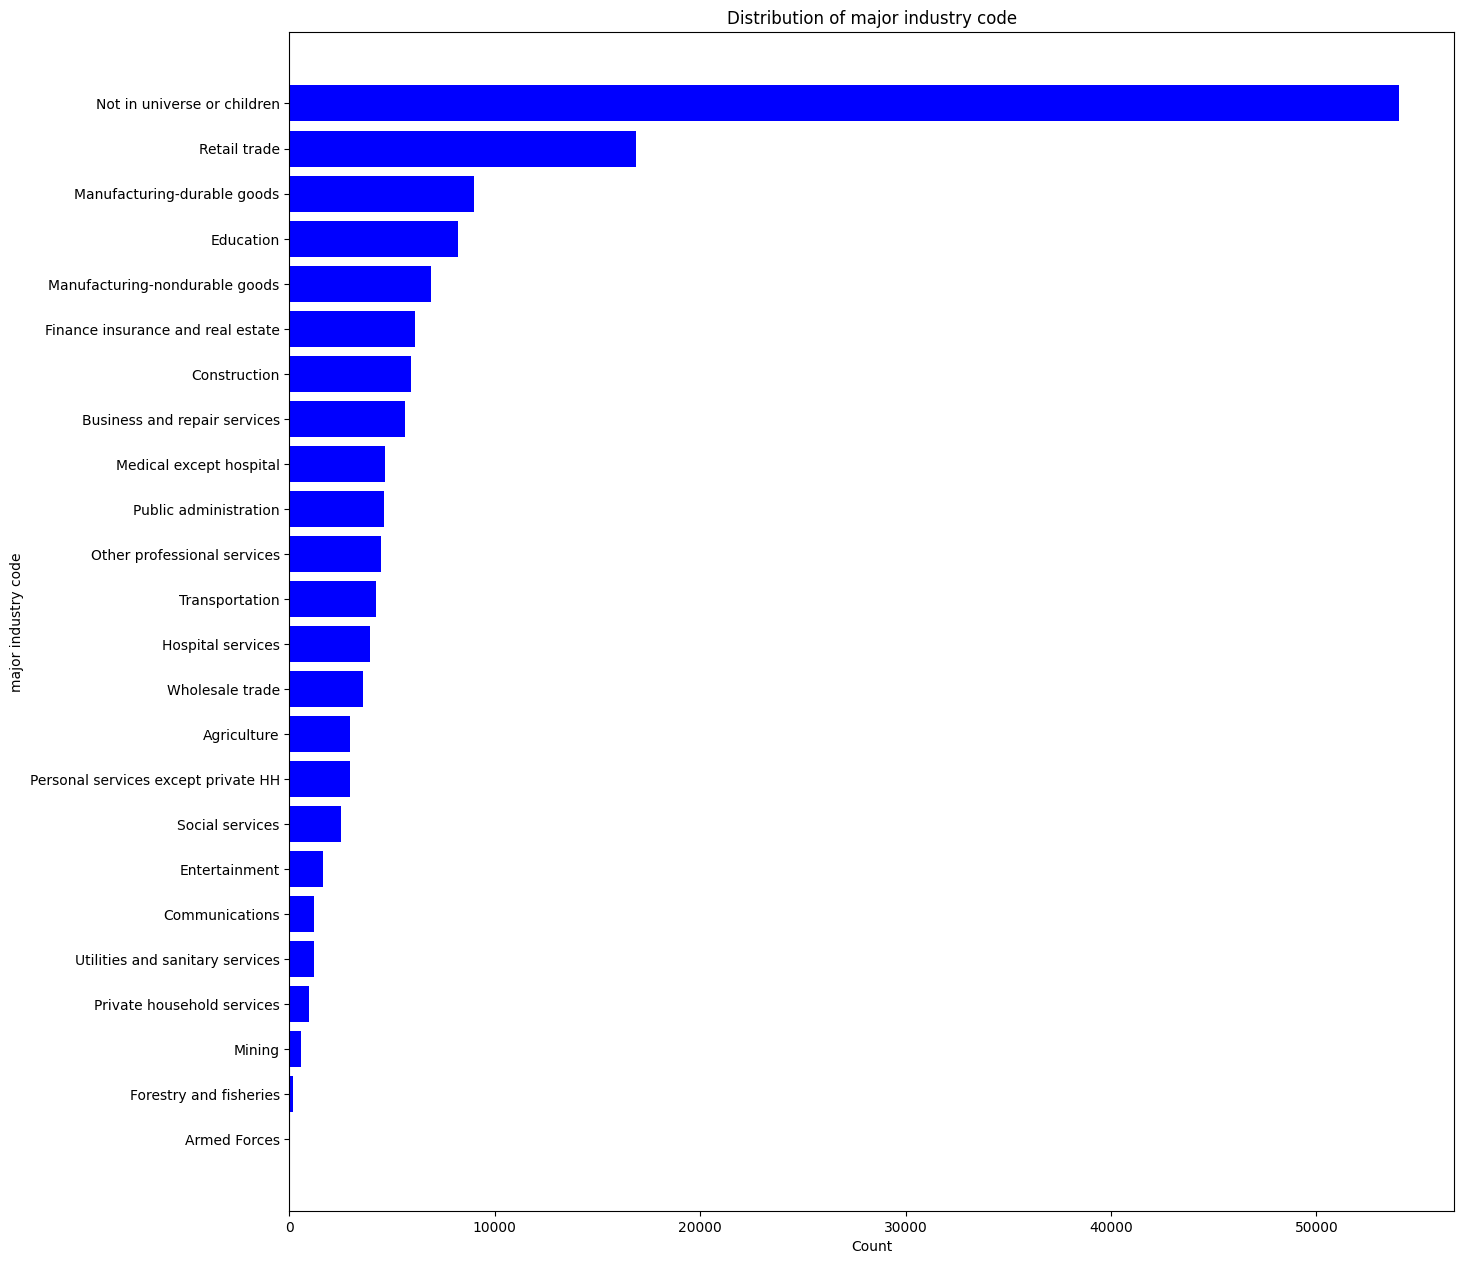

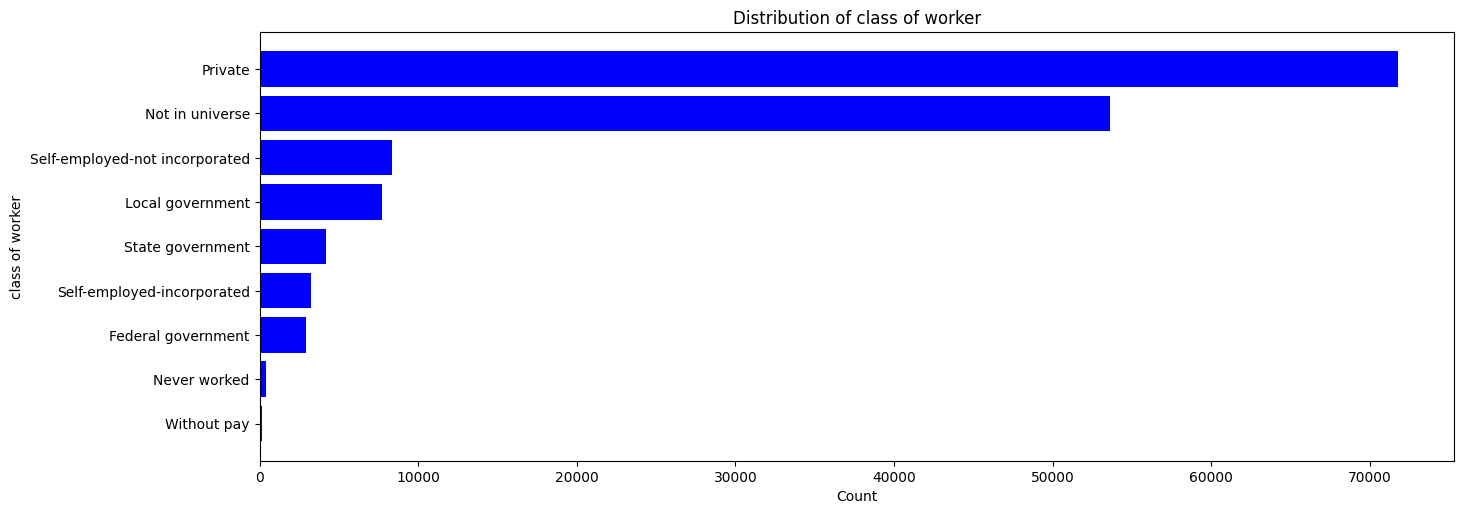

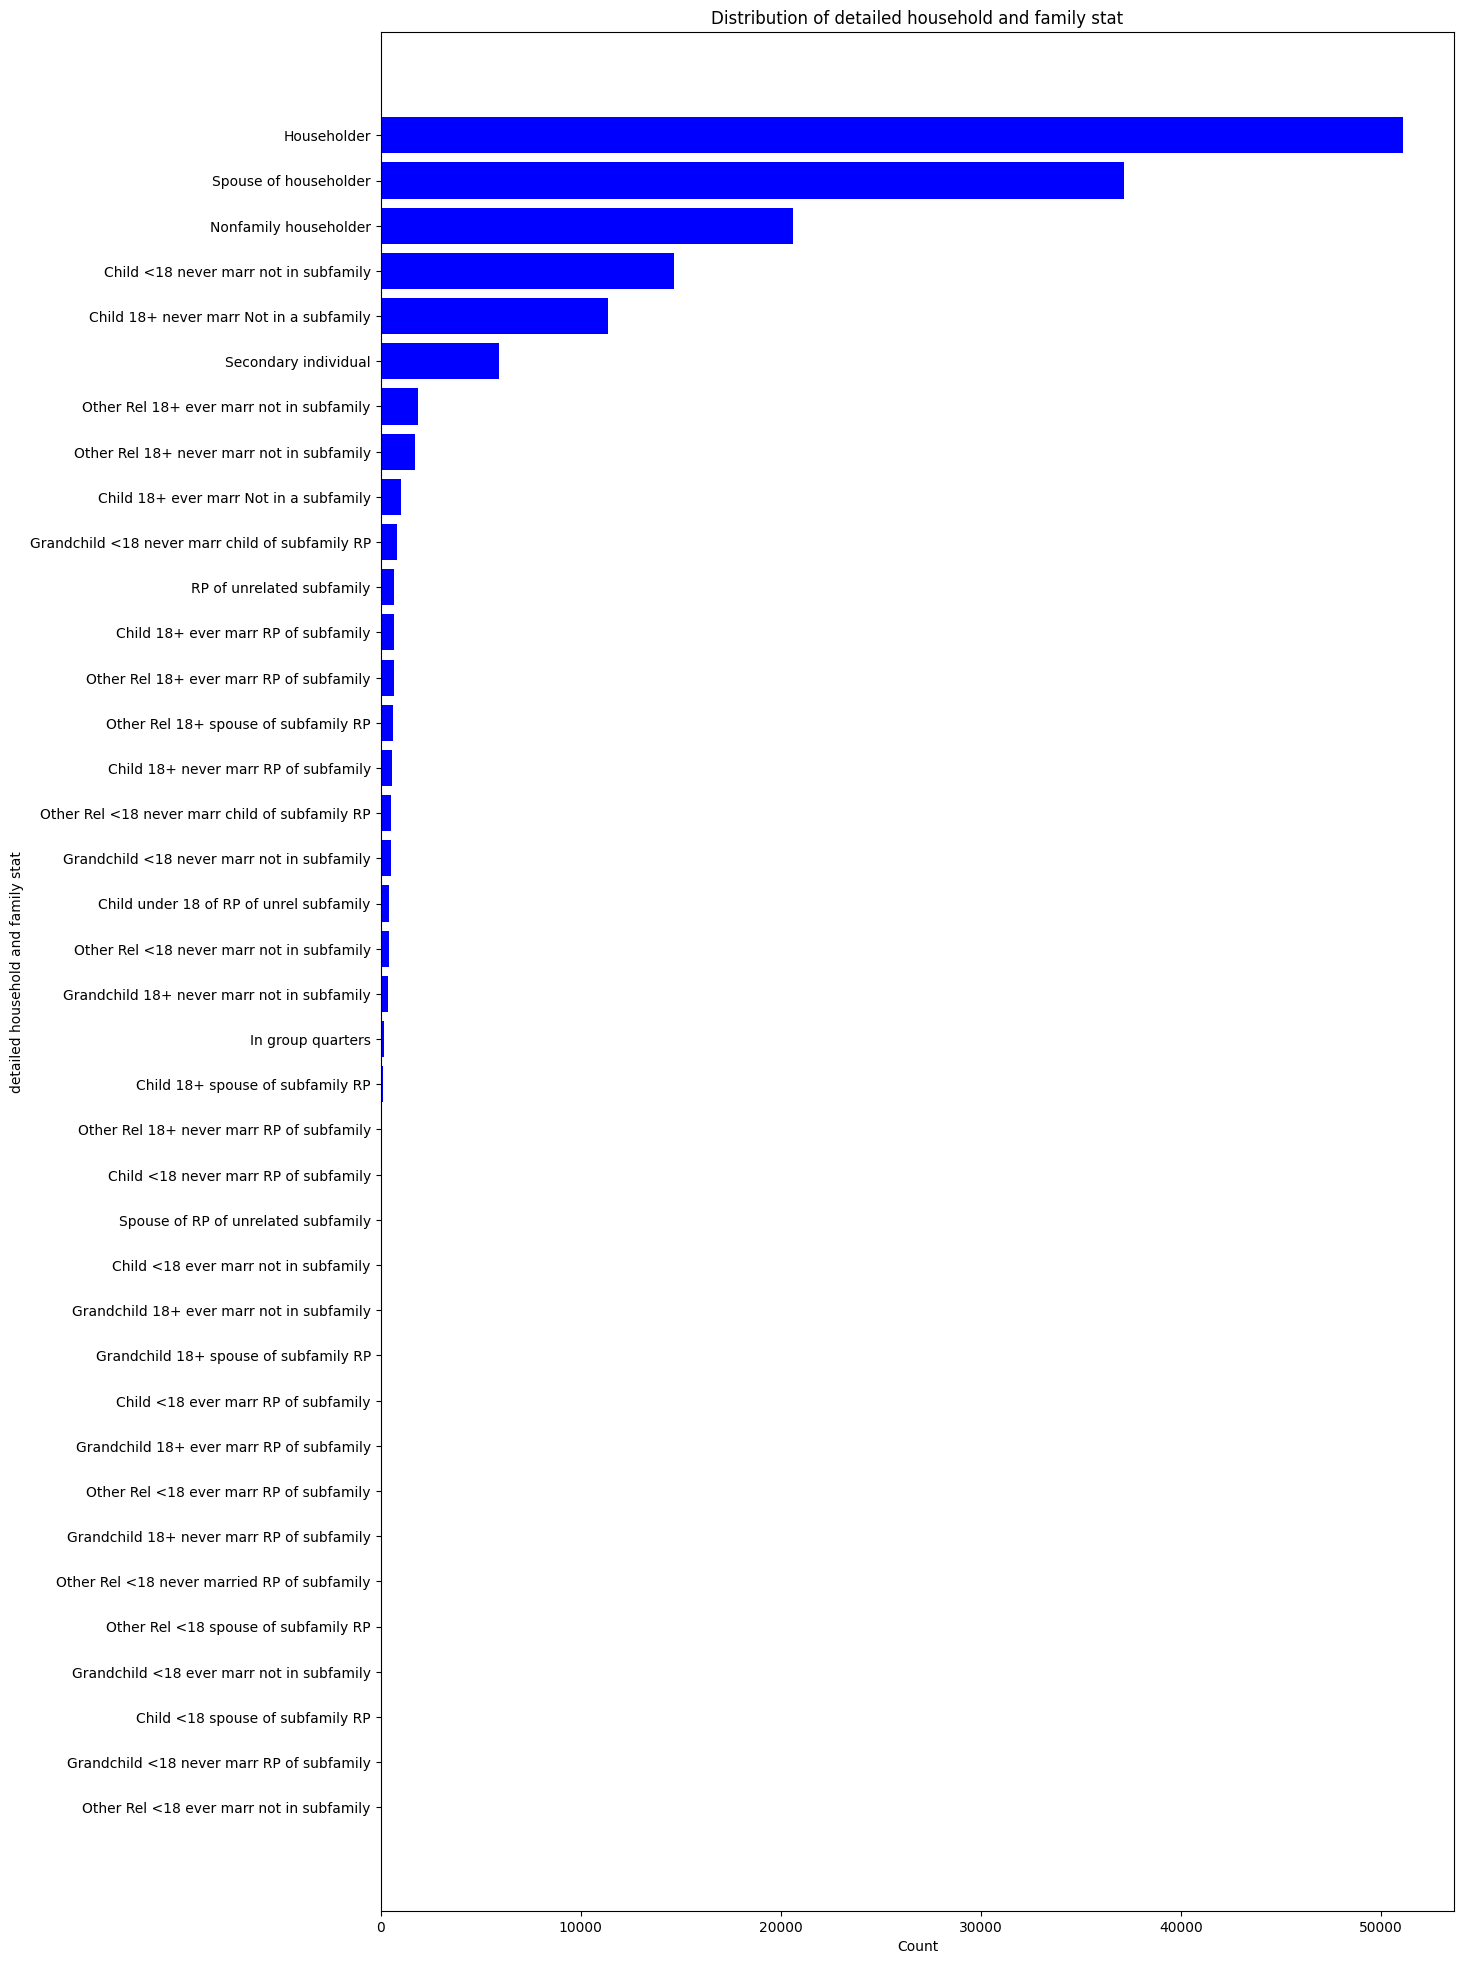

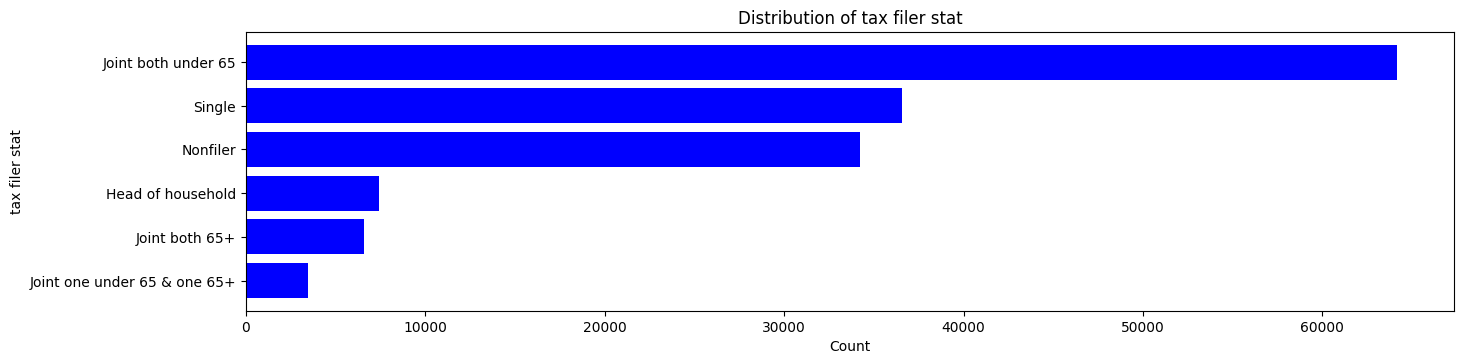

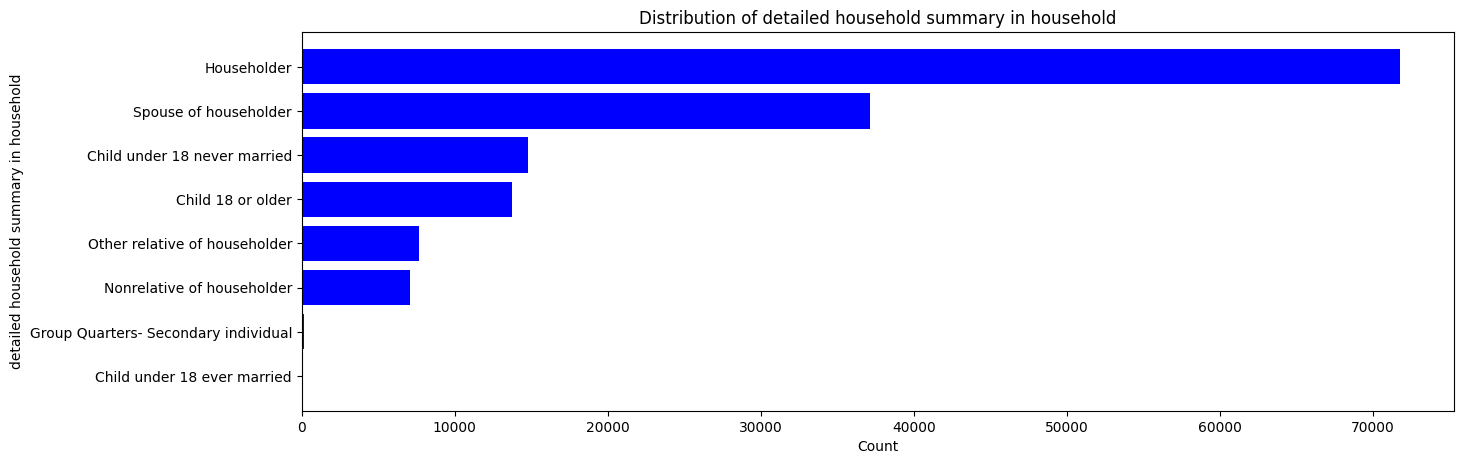

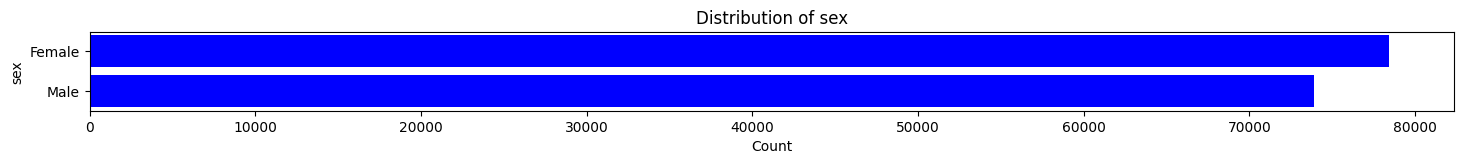

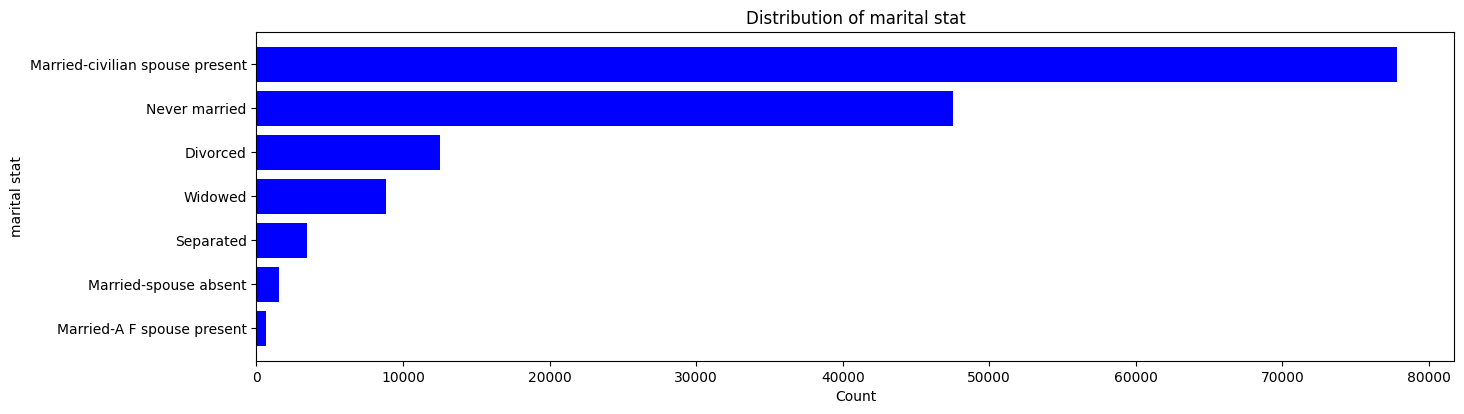

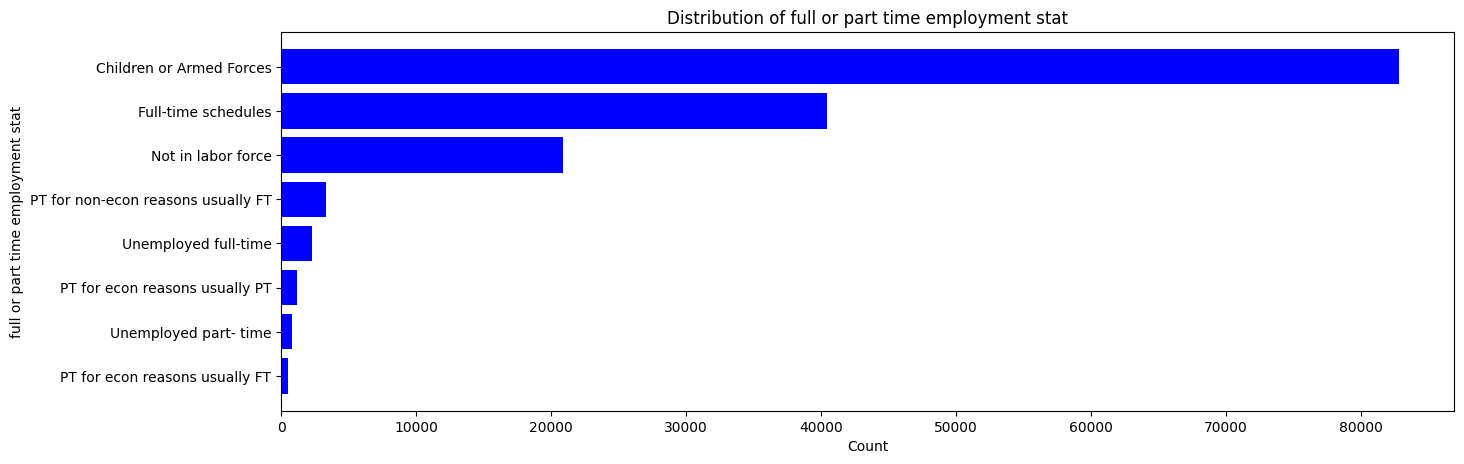

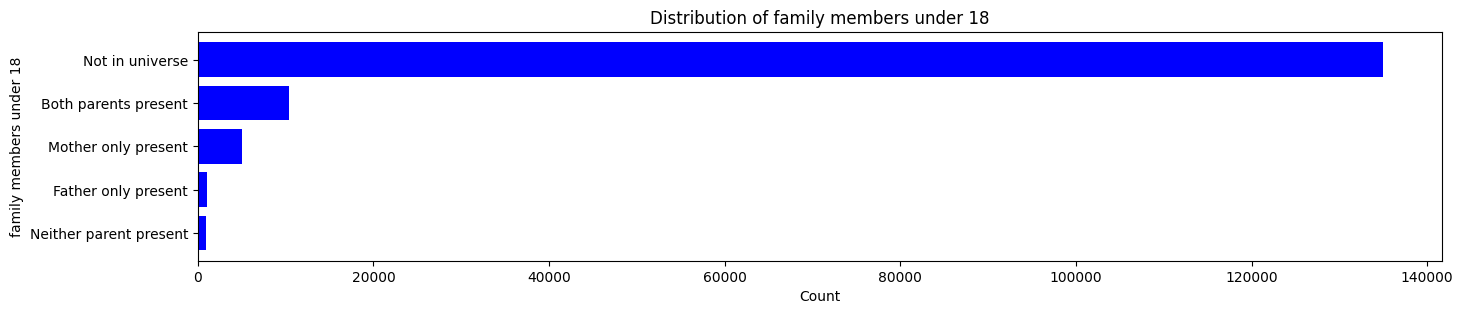

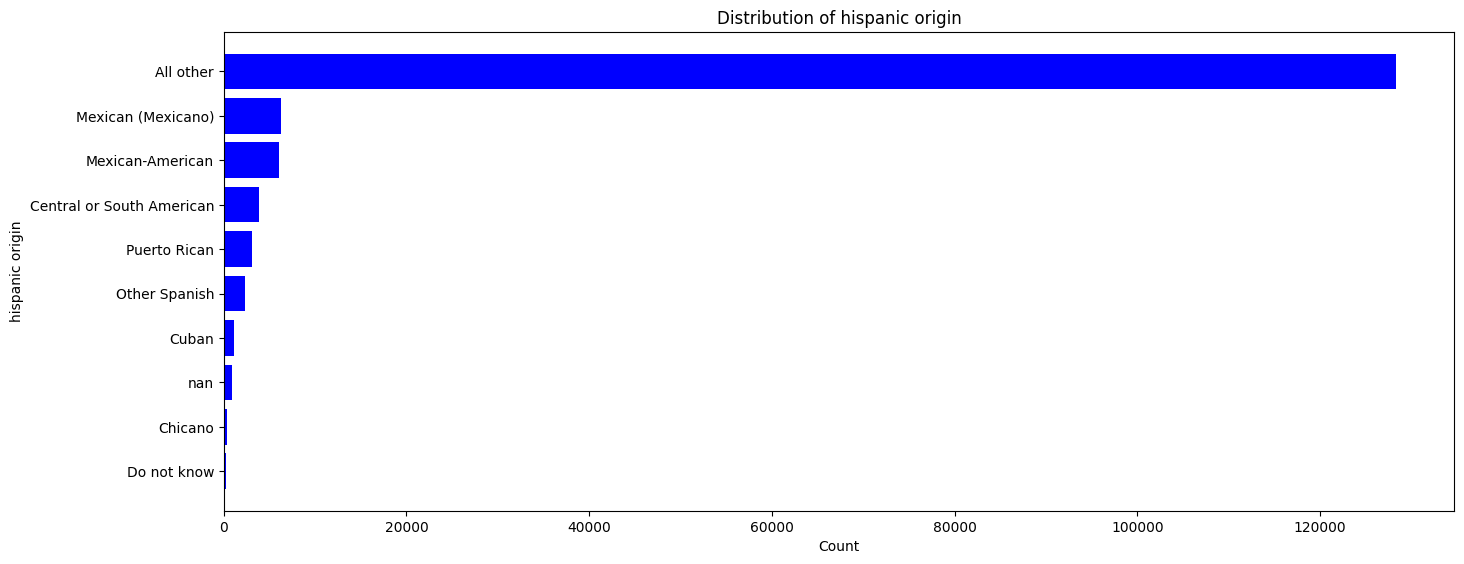

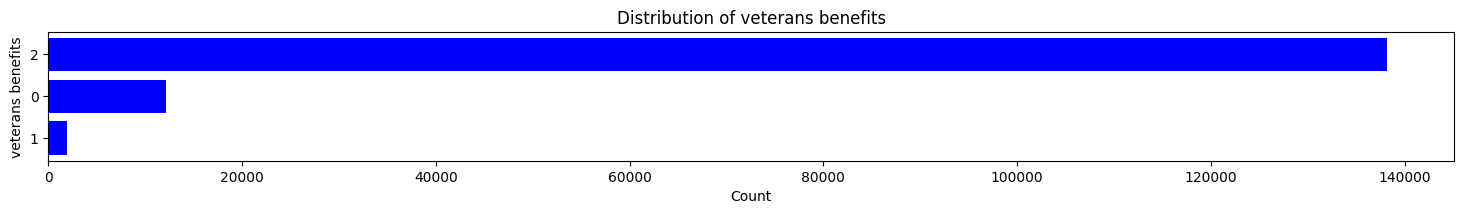

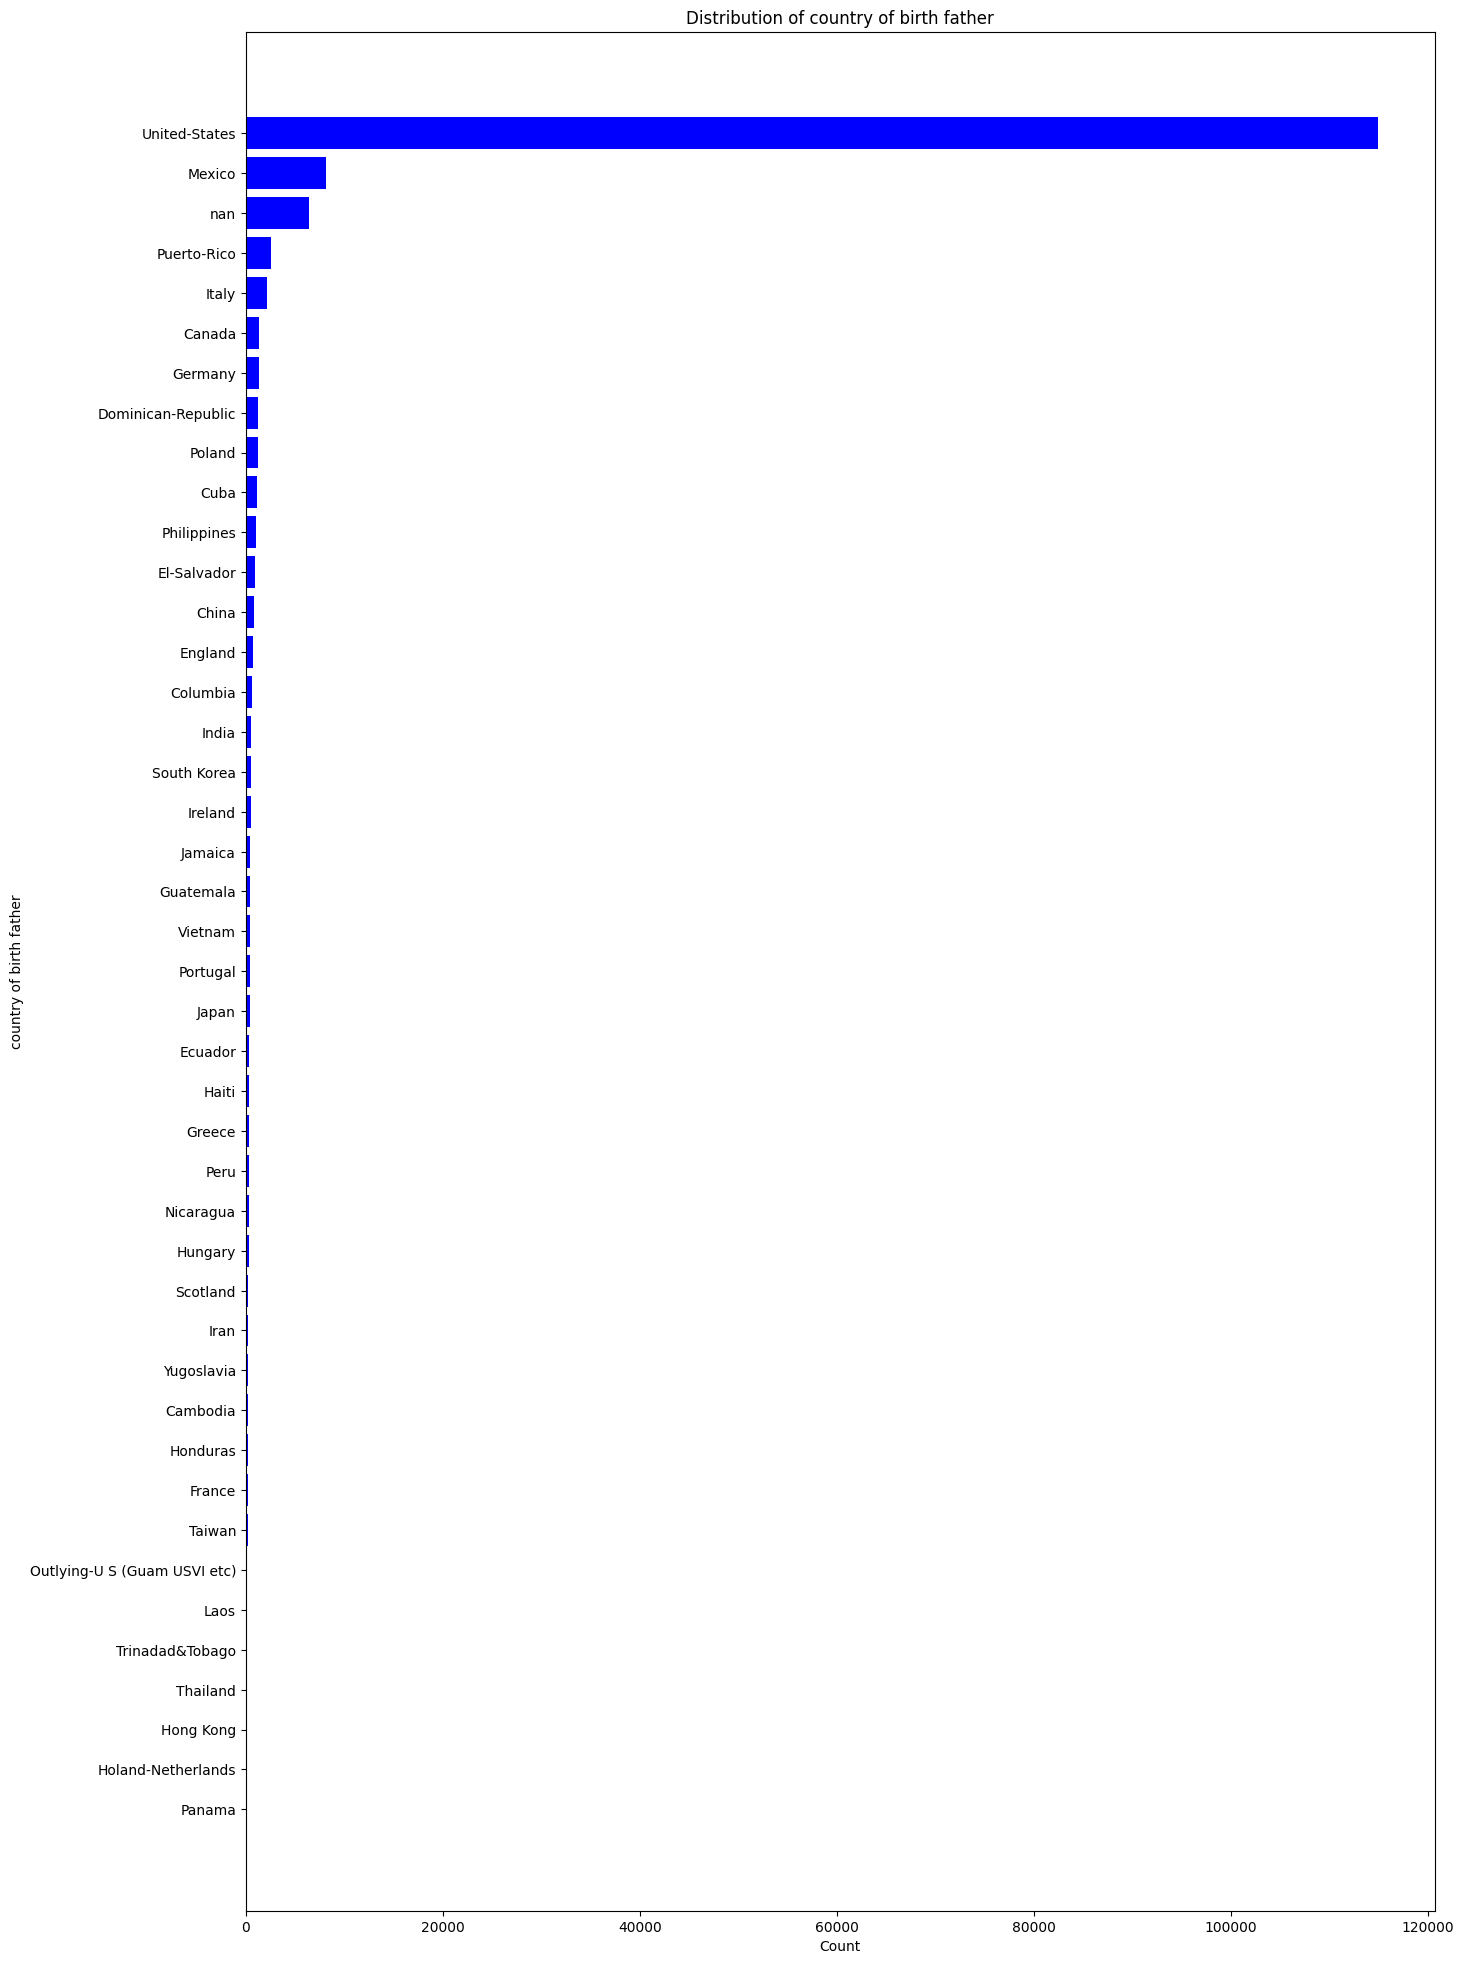

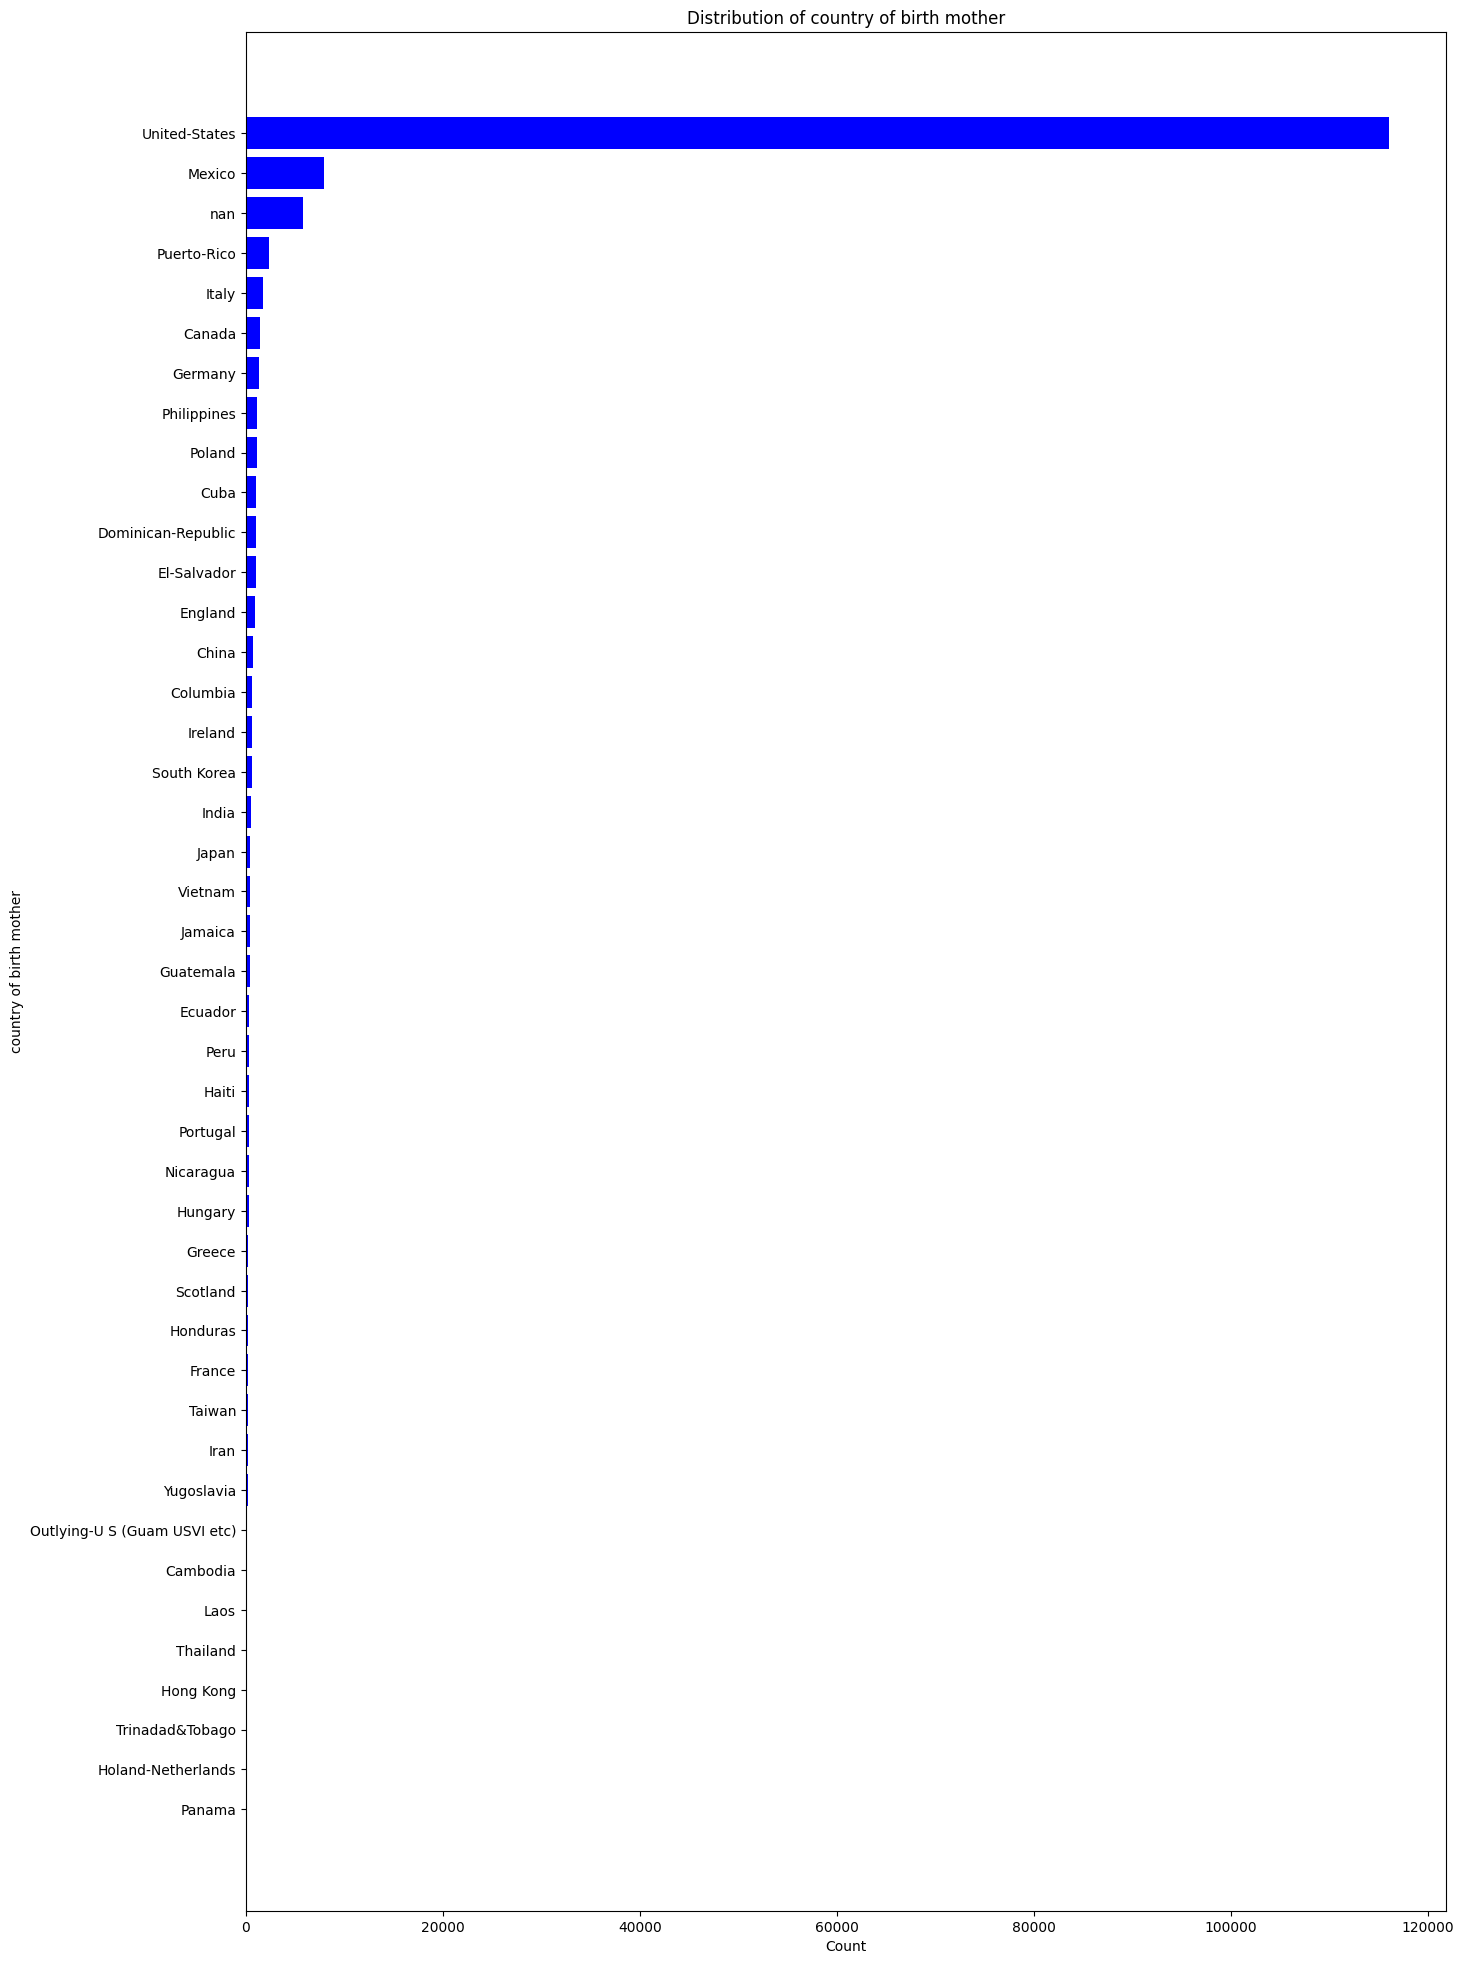

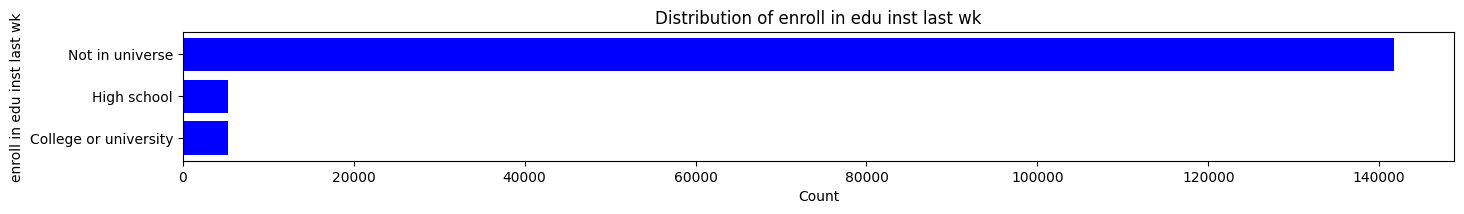

In [23]:
shortlisted_cols = stat_results['Column'].head(18)
eda_obj.bar_plots_of_nominal(shortlisted_cols)


<b> Insights: </b>

1. Many categories in the dataset like 'detailed occupation recode', 'education', 'major occupation code' etc. have highly skewed distributions with dominant values
2. Some features have 'Not in universe' like major occupation codes and class of workers, indicating that either a substantial proportion of data is missing or may represent people who are not working
3. Most people as well as their parents have been born in the united states 
4. There are features like "country of birth mother", "country  of birth father", "detailed of household and family stat" are quite sparse and have a lot of categories. It'd be best to group the lower frequency categories into a single category like "other"


Lots of these features will need to be encoded using different ways in order to train the models. 

<b><u>Proportion Analysis of Income Distribution in Nominal Features

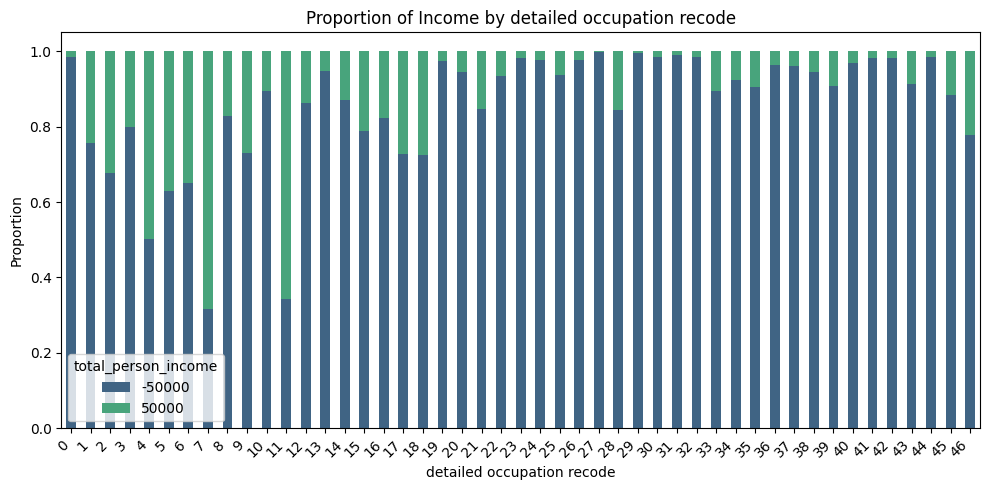

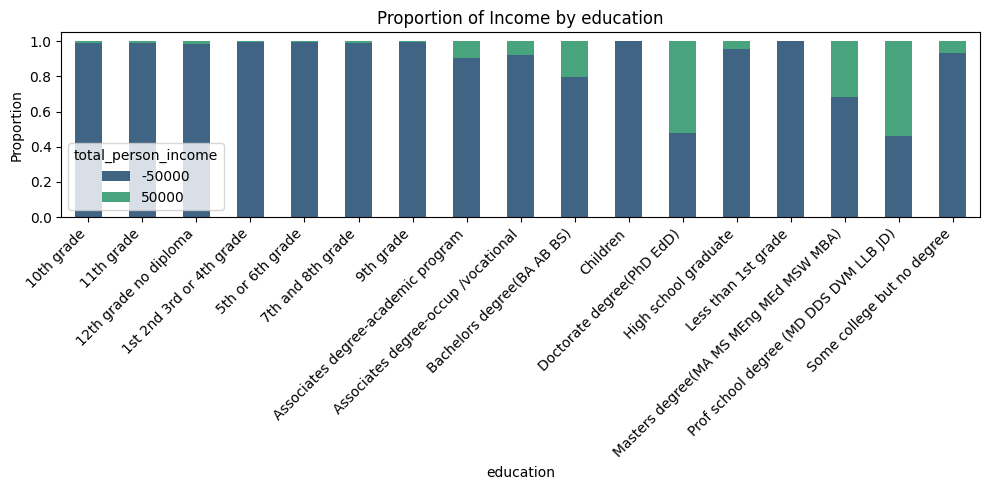

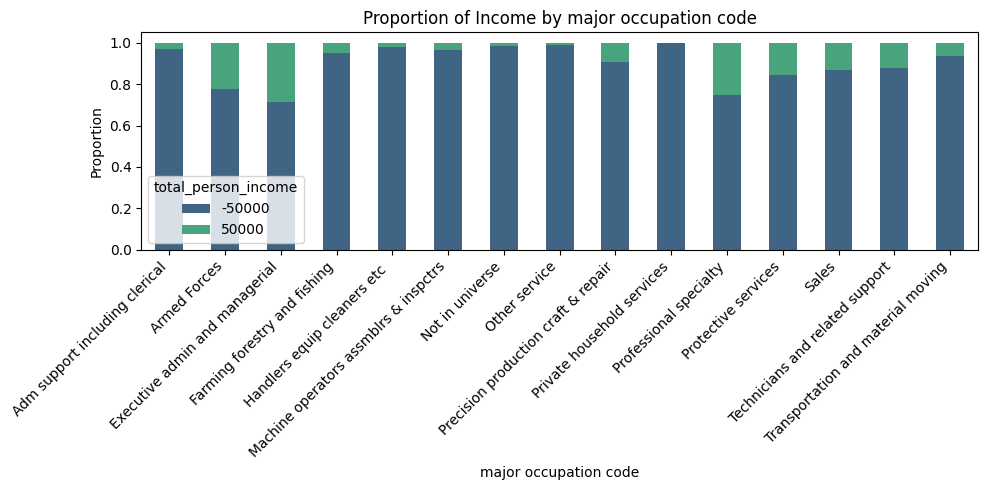

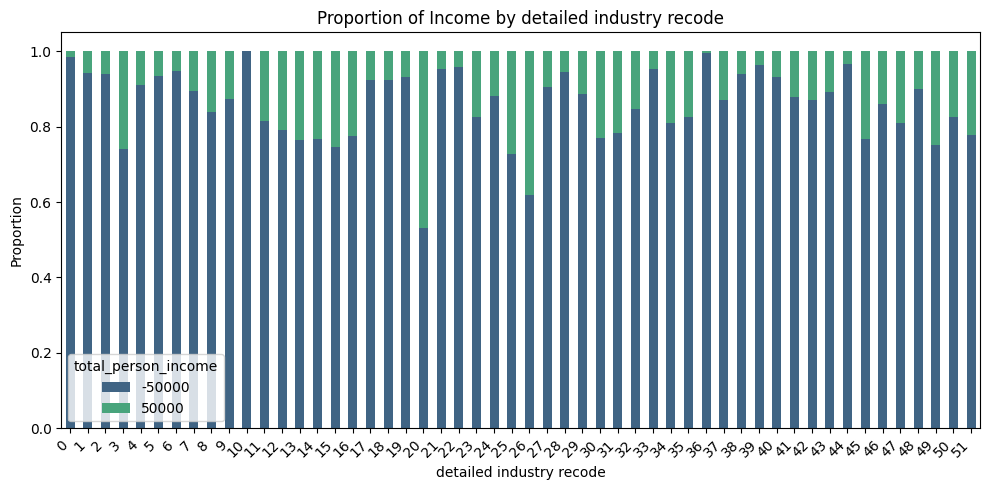

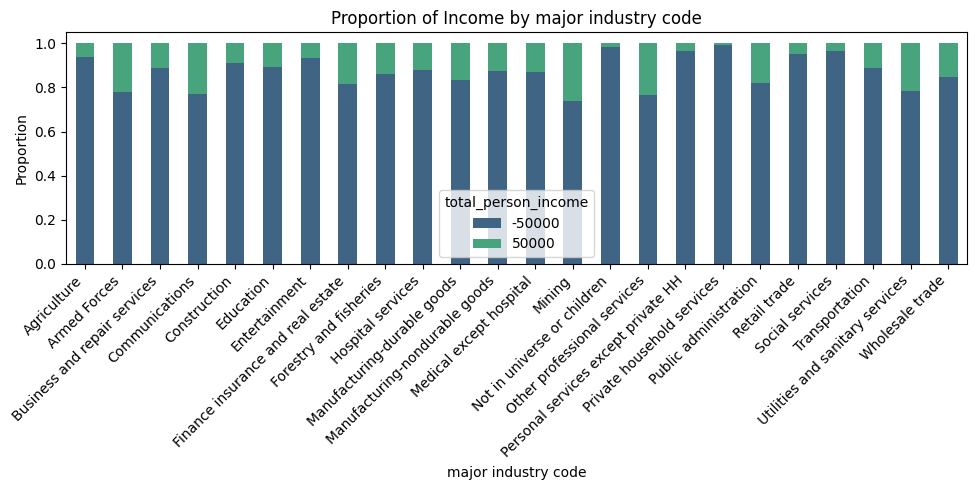

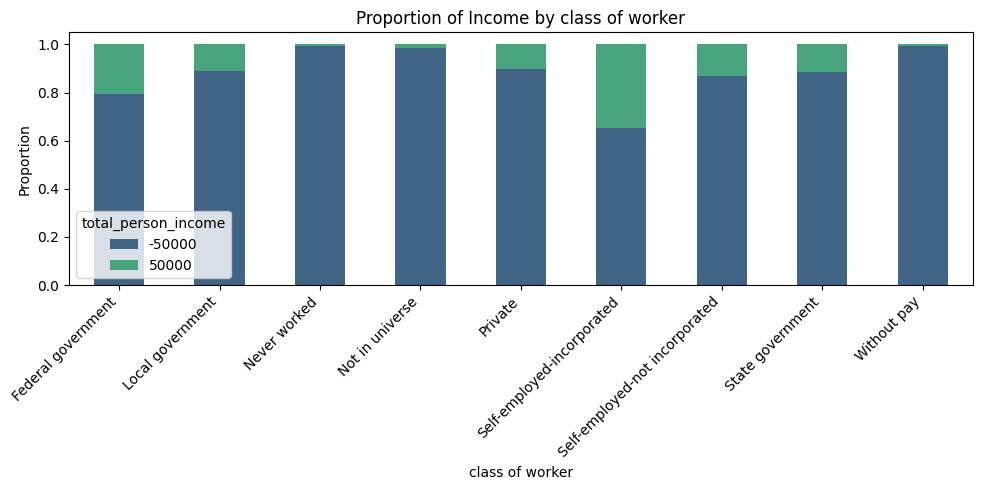

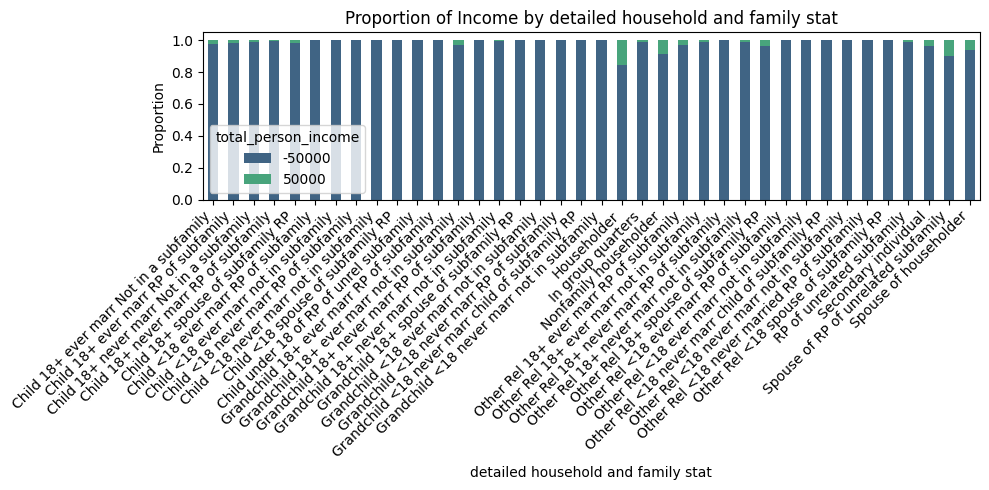

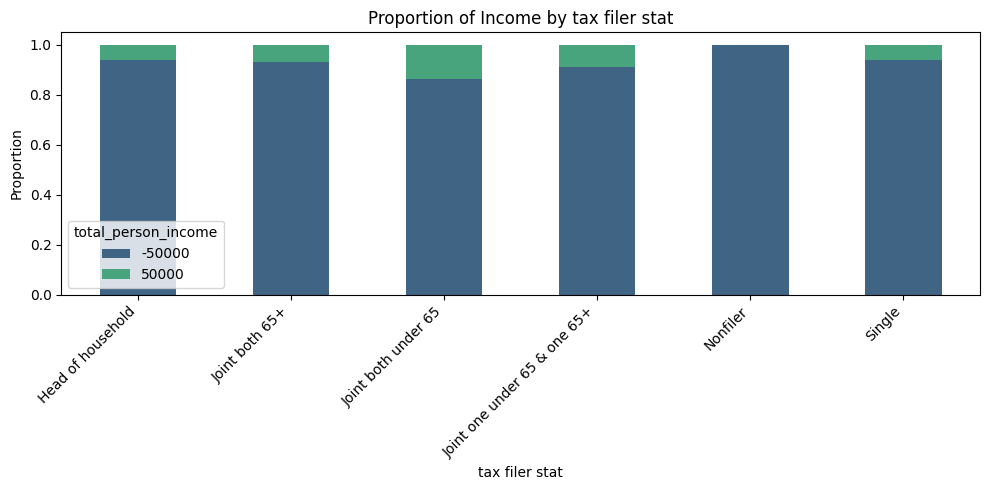

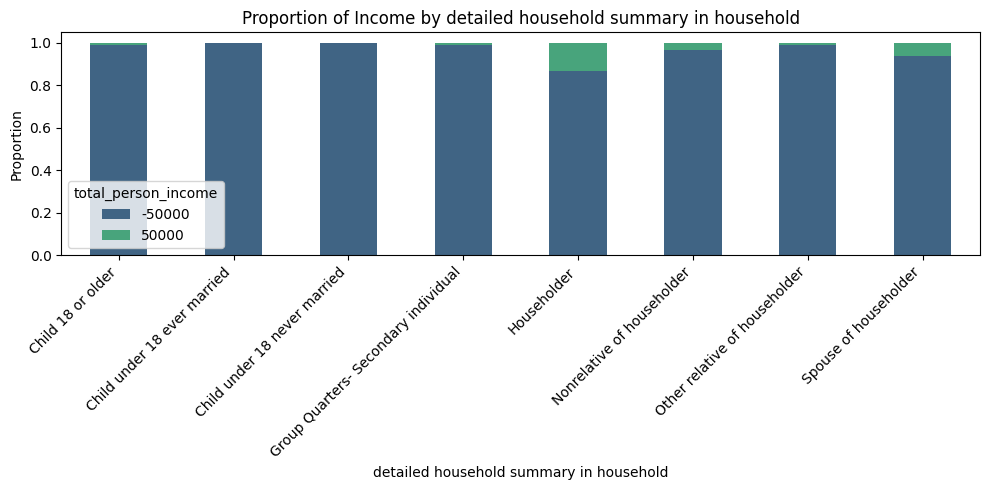

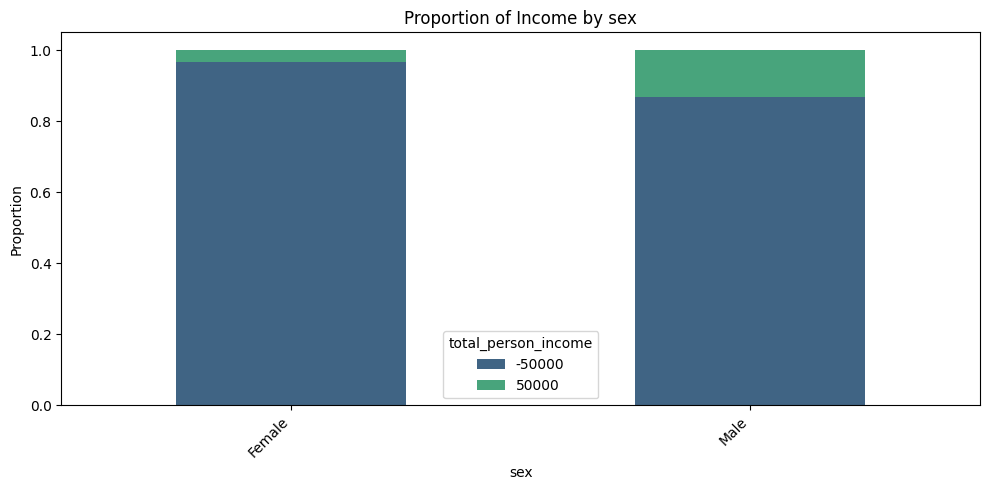

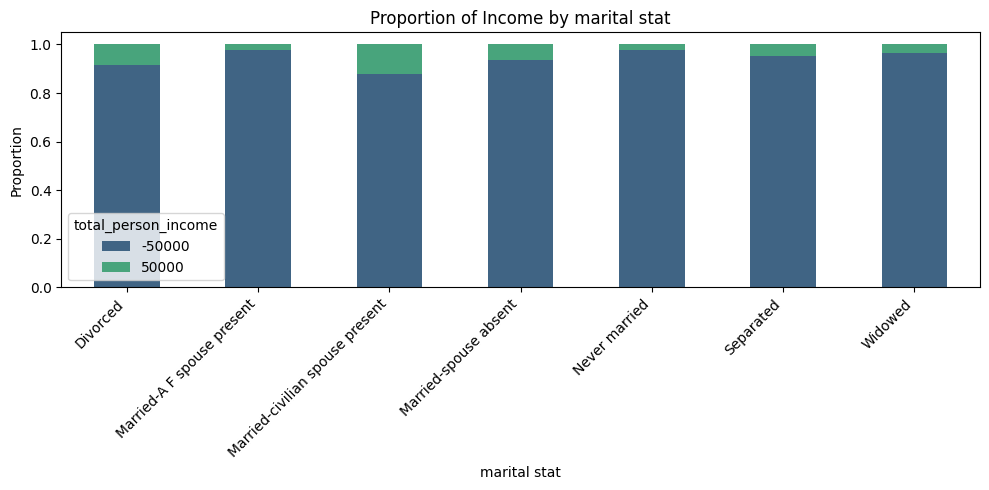

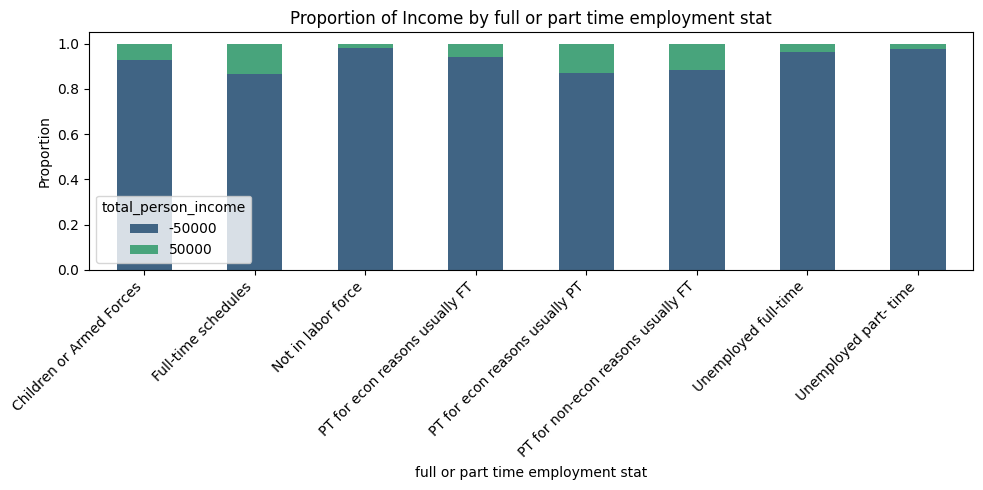

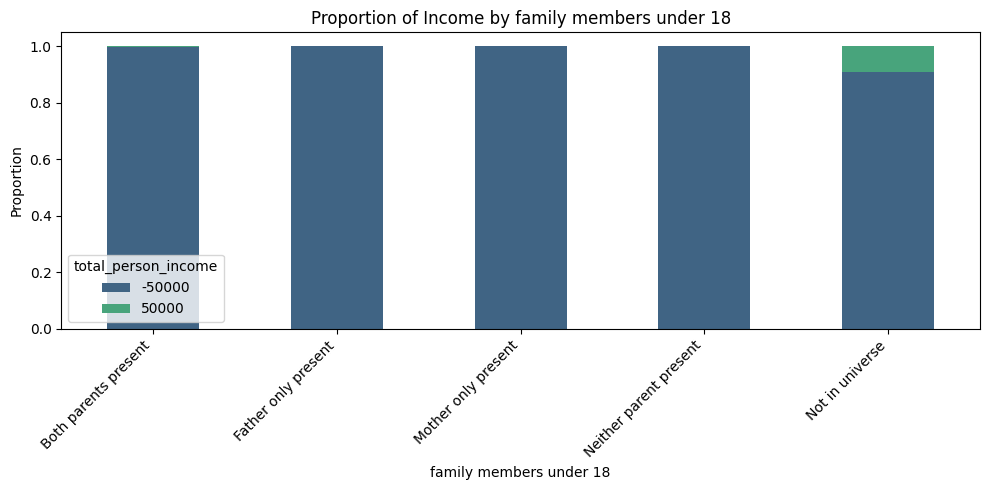

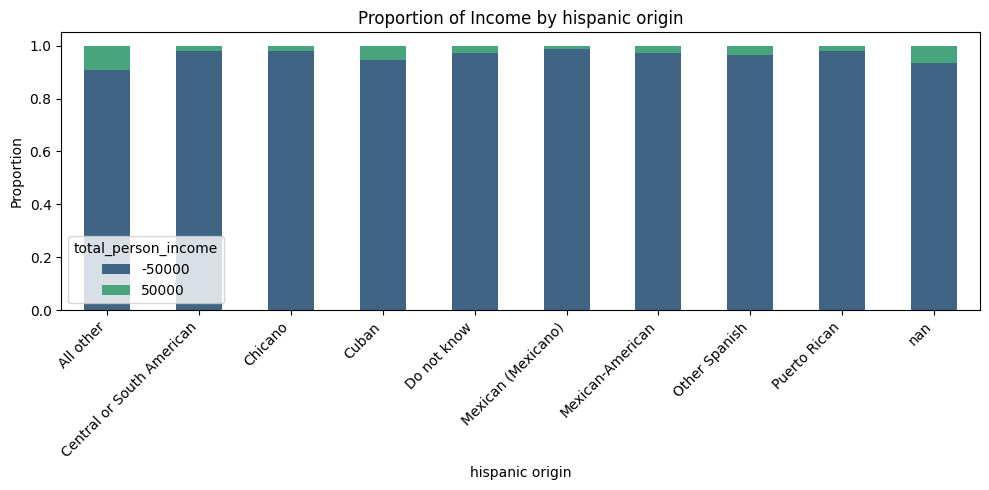

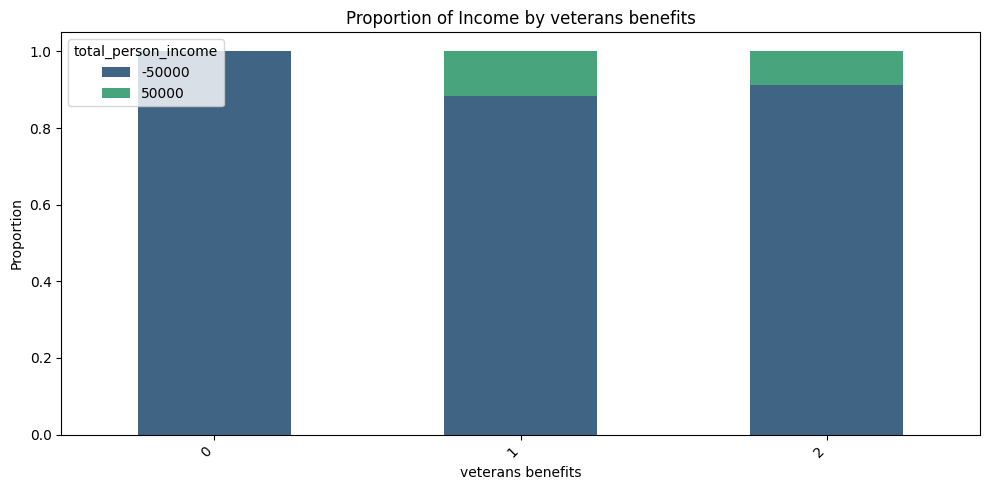

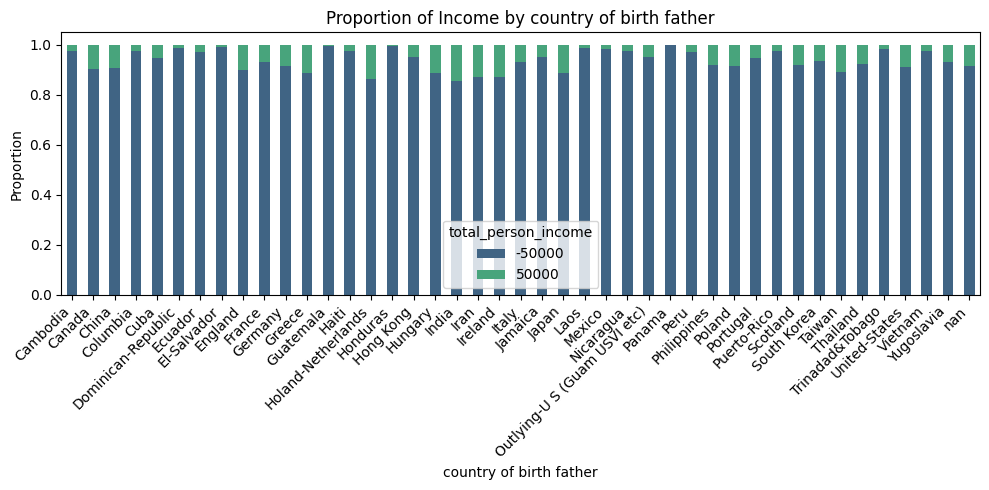

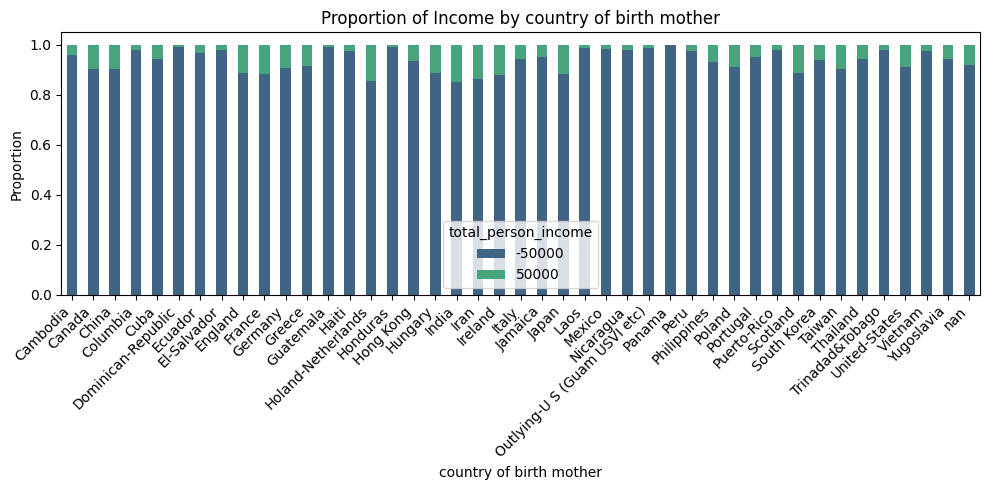

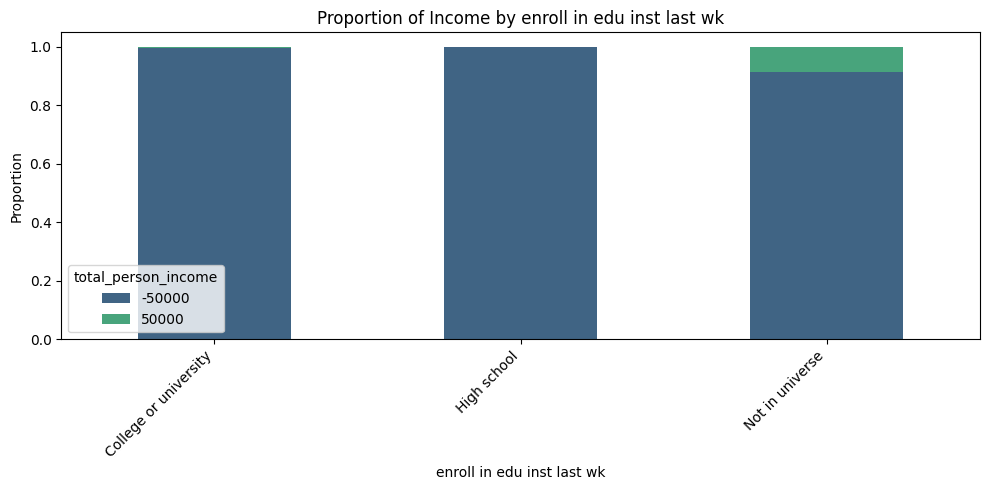

In [24]:
eda_obj.stacked_bar_proportions(shortlisted_cols)

<u> Key Insights

1. There's significant variation in proportion of income categories across occupations in detailed occupation recode which makes it useful to identify occupations associated with high or low incomes.
2. Higher education levels, like bachelor's, master's and doctorate degrees show a higher proportion of incomes above 50,000. 
3. Clerical, managerial and professional specialties have higher proportion of incomes above 50,000, while lower income proportions are observed for farming, cleaning, and labor-intensive roles.
4. Majority of categories in household and family stat are dominated by incomes below 50,000 except householders and spouses, who show slightly higher income distributions as the spouses could be working or have joint income and householders are asset rich and are accumulating passive income.
5. Even though the distribution of categories in the previous section showed that there are more females than males, it's the male gender that has a higher proportion of income above 50,000 highlighting gender income disparity 

<b> <u>Modelling

The following section will address some of the concerns highlighted in the exploratory data analysis section using feature engineering techniques, then use 3 machine learning techniques to classify income. 

<u>Feature Engineering

To enhance predictive power, the following new features have been created manually:

Binary Indicators:
1. has_capital_gains: Identifies whether a person has any capital gains.
2. is_full_time: Identifies whether a person has worked 40 or more weeks.

Ratios:
1. capital_losses_to_age: Normalizes capital losses by age to capture proportional impact per at every age. For unemployed people this would just be 0.
2. capital_gains_to_hours: Normalizes capital gains by wage per hour to assess just how efficient the income is for the time worked.
3. wage_per_age: Normalizes hourly wage by age; this gives brief insight into potential earnings based on experience through the years.

Interaction Terms:
1. income_potential: Combines age, weeks worked, and wage per hour to come up with rough figure of earnings potential. 

Additionally, there are polynomial interaction features created for continuous variables in the transformation step. It is possible to create more interaction features however ensemble modelling techniques are good at automatically learning interactions between features. 

<u> Preprocessing & Feature Transformation

1. The total person income is converted from "-50000 ." and "50000+." to 0 and 1 for better model interpretability
2. Top 20 features of 'country of birth father', 'country of birth mother', 'detailed household and family stat' and 'major occupation code' were taken while the rest were groped into "Other"
3. 'capital gains', 'capital losses', 'dividends from stocks' and 'wage per hour' are log transformed to handle skewness and sparsity
4. Nominal features with low cardinality are label-encoded while features with high cardinality are target encoded.
5. Continuous features are also scaled using Standard Scaler; even though ensemble methods don't require scaling, the baseline model which is probabilistic will need said features scaled   
6. The training data is then balanced using SMOTE + Tomek Links; SMOTE generates synthetic samples for the minority class while Tomek identifies pairs of samples that are overlapping and removes them from majority class
    
    6.1 The oversampling of minority class is only done upto 50% of the majority class as that reflects real-world scenarios where income distribution is typically skewed and prevents overfitting of the model 

<u> Modelling Techniques

There are 3 classifiers used:
1. Logistic Regression: This is the baseline model that uses shortlisted feature space that contains all the continuous features, generated features and shortlisted categorical features based on Cramer's V scores.
2. XGBoost: It leverages gradient boosting technique to reduce bias, variance; and also allows tuning scale_pos_weight parameter to handle class imbalance. 

    2.1 It's fitted on a shortlisted feature space that contains all the continuous features, generated features and shortlisted categorical features based on Cramer's V scores. This is done as XGBoost can be time inefficient with data of this size
3. LightGBM: It also works on the principle of gradient boosting but has much faster computation compared to XGBoost. 

    3.1 Due to it's speed, it also initially uses the entire feature space and then finds the best feature upon which LightGBM is fit again.


In all three cases, hyperparameter tuning is done through randomizedsearchCV and evaluation is done through StratifiedKFold cross validation so that each fold has similar distribution of total person income as the entire dataset. It's good for handling class imbalance as the it eliminates disproporationate amounts of < 50000 and > 50000.

<u> Model Evaluation

For evaluating the model performance, main metrics used are:
1. Precision: Correctly identifies people with high and low income
2. Recall: Measures the ability to capture all actual positives
3. F1 Score: Balances precision and recall, which is very useful for imbalanced datasets
4. ROC-AUC: Indicates how well the model is able to discriminate between classes at various thresholds

In [25]:
final_learn = eda_obj.learn_df.copy()
final_test = eda_obj.test_df.copy()
final_learn.drop('instance weight', axis=1, inplace=True)
final_test.drop('instance weight', axis=1, inplace=True)


In [26]:
fe_lr = FeatureEngineer(final_learn, final_test)
fe_lr.create_new_features()
fe_lr.binarize_target()
fe_lr.group_rare_countries()
fe_lr.log_transform()

fe_lr.label_or_target_encode(shortlisted_cols, threshold=10, n_splits=5)
continuous_features = [
    'age','capital gains_log', 'capital losses_log', 'dividends from stocks_log', 'wage per hour_log',
    'num persons worked for employer','weeks worked in year','capital_losses_to_age',
    'capital_gains_to_hours','wage_per_age','income_potential'
]

fe_lr.ensure_numeric() 

learn_lr = fe_lr.learn_df.copy()
test_lr = fe_lr.test_df.copy()

trainer_lr = ModelTrainer(learn_lr, test_lr, target_col="total_person_income")
X_train_lr, X_test_lr, y_train_lr, y_test_lr = trainer_lr.get_train_test()

existing_num_cols = [c for c in continuous_features if c in X_train_lr.columns]
preprocessor = trainer_lr.build_preprocessor(existing_num_cols)

X_train_t, X_test_t = trainer_lr.transform_with_preprocessor(preprocessor, X_train_lr, X_test_lr)

X_train_res, y_train_res = trainer_lr.smote_tomek_resample(X_train_t, y_train_lr)


trainer_lr.train_logistic_regression(X_train_res, y_train_res)

Low Cardinality Columns (Label Encoded): ['class of worker', 'tax filer stat', 'detailed household summary in household', 'sex', 'marital stat', 'full or part time employment stat', 'family members under 18', 'hispanic origin', 'veterans benefits', 'enroll in edu inst last wk']
High Cardinality Columns (Target Encoded): ['detailed occupation recode', 'education', 'major occupation code', 'detailed industry recode', 'major industry code', 'detailed household and family stat', 'country of birth father', 'country of birth mother']
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression Best parameters: {'penalty': 'l2', 'C': 10.0}


Model: lr
                  precision    recall  f1-score   support

   Less than 50k       0.98      0.92      0.95     72217
Greater than 50k       0.44      0.75      0.55      6162

        accuracy                           0.90     78379
       macro avg       0.71      0.83      0.75     78379
    weighted avg       0.93      0.90      0.92     78379

Evaluation Metrics:
precision    0.435118
recall       0.750406
f1           0.550837
roc_auc      0.930747
dtype: float64
Confusion Matrix:


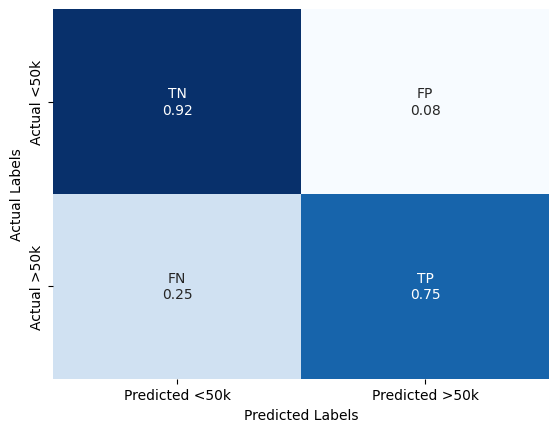

In [27]:
trainer_lr.evaluate_model('lr', X_test_t, y_test_lr)

In [28]:
cols_to_analyze = [
    'citizenship','class of worker','country of birth father','country of birth mother',
    'country of birth self','detailed household and family stat',
    'detailed household summary in household','detailed industry recode','detailed occupation recode',
    'education','enroll in edu inst last wk','family members under 18',
    "fill inc questionnaire for veteran's admin",'full or part time employment stat','hispanic origin',
    'live in this house 1 year ago','major industry code','major occupation code','marital stat',
    'member of a labor union','own business or self employed','race','reason for unemployment',
    'region of previous residence','sex','state of previous residence','tax filer stat',
    'veterans benefits','year'
]

In [29]:
final_learn = eda_obj.learn_df.copy()
final_test = eda_obj.test_df.copy()
final_learn.drop('instance weight', axis=1, inplace=True)
final_test.drop('instance weight', axis=1, inplace=True)

In [30]:

fe_lgb = FeatureEngineer(final_learn, final_test)
fe_lgb.create_new_features()
fe_lgb.binarize_target()
fe_lgb.group_rare_countries()
fe_lgb.log_transform()
fe_lgb.label_or_target_encode(cols_to_analyze, threshold=10, n_splits=5)
fe_lgb.ensure_numeric() 
learn_lgb = fe_lgb.learn_df.copy()
test_lgb = fe_lgb.test_df.copy()

Low Cardinality Columns (Label Encoded): ['citizenship', 'class of worker', 'detailed household summary in household', 'enroll in edu inst last wk', 'family members under 18', "fill inc questionnaire for veteran's admin", 'full or part time employment stat', 'hispanic origin', 'live in this house 1 year ago', 'marital stat', 'member of a labor union', 'own business or self employed', 'race', 'reason for unemployment', 'region of previous residence', 'sex', 'tax filer stat', 'veterans benefits', 'year']
High Cardinality Columns (Target Encoded): ['country of birth father', 'country of birth mother', 'country of birth self', 'detailed household and family stat', 'detailed industry recode', 'detailed occupation recode', 'education', 'major industry code', 'major occupation code', 'state of previous residence']


In [31]:
trainer_lgb = ModelTrainer(learn_lgb, test_lgb, target_col="total_person_income")
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = trainer_lgb.get_train_test()
existing_num_cols = [c for c in continuous_features if c in X_train_lgb.columns]
preprocessor = trainer_lgb.build_preprocessor(existing_num_cols)
X_train_t, X_test_t = trainer_lgb.transform_with_preprocessor(preprocessor, X_train_lgb, X_test_lgb)
X_train_res, y_train_res = trainer_lgb.smote_tomek_resample(X_train_t, y_train_lgb)
trainer_lgb.train_lightgbm(X_train_res, y_train_res)

[LightGBM] [Info] Number of positive: 55028, number of negative: 111040
[LightGBM] [Info] Number of positive: 55028, number of negative: 111040
[LightGBM] [Info] Number of positive: 55028, number of negative: 111040
[LightGBM] [Info] Number of positive: 55028, number of negative: 111040
[LightGBM] [Info] Number of positive: 55028, number of negative: 111040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 166068, number of used features: 93
[LightGBM] [Info] Total Bins 21956
[LightGBM] [Info] Number of data points in the train set: 166068, number of used feature

Model: lgb
                  precision    recall  f1-score   support

   Less than 50k       0.96      0.98      0.97     72217
Greater than 50k       0.72      0.51      0.60      6162

        accuracy                           0.95     78379
       macro avg       0.84      0.75      0.79     78379
    weighted avg       0.94      0.95      0.94     78379

Evaluation Metrics:
precision    0.719111
recall       0.514768
f1           0.600019
roc_auc      0.943098
dtype: float64
Confusion Matrix:


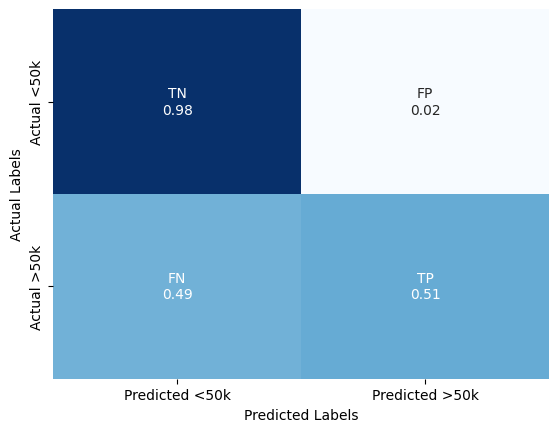

In [32]:
trainer_lgb.evaluate_model('lgb', X_test_t, y_test_lgb)

In [33]:
trainer_lgb.print_feature_imp('lgb', preprocessor)

                                              Feature  Importance
94                            remainder__education_te        5039
93           remainder__detailed occupation recode_te        3978
92             remainder__detailed industry recode_te        3719
96                remainder__major occupation code_te        3261
16           num__age num persons worked for employer        3243
1                                            num__age        3027
95                  remainder__major industry code_te        2866
17                      num__age weeks worked in year        2766
91   remainder__detailed household and family stat_te        2364
97          remainder__state of previous residence_te        2107
88              remainder__country of birth father_te        2064
68                         remainder__class of worker        2044
89              remainder__country of birth mother_te        1976
90                remainder__country of birth self_te        1758
4         

Refitting the best estimator for model lgb on filtered features


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 68785, number of negative: 138800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15991
[LightGBM] [Info] Number of data points in the train set: 207585, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331358 -> initscore=-0.702048
[LightGBM] [Info] Start training from score -0.702048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

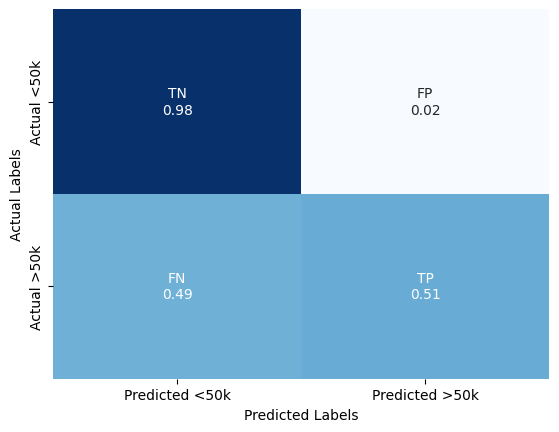

In [34]:
trainer_lgb.feature_importance_filter_and_refit(model_key='lgb', preprocessor=preprocessor, X_train=X_train_res, y_train=y_train_res, X_test=X_test_t,y_test=y_test_lgb, importance_threshold=100, refit_entire_search=False)

In [35]:
final_learn = eda_obj.learn_df.copy()
final_test = eda_obj.test_df.copy()
final_learn.drop('instance weight', axis=1, inplace=True)
final_test.drop('instance weight', axis=1, inplace=True)

In [36]:
learn_xgb_base = final_learn.copy()
test_xgb_base = final_test.copy()


In [37]:
fe_xgb = FeatureEngineer(learn_xgb_base, test_xgb_base)
fe_xgb.create_new_features()

In [38]:
fe_xgb.binarize_target()
fe_xgb.group_rare_countries()
fe_xgb.log_transform()
fe_xgb.label_or_target_encode(shortlisted_cols, threshold=10, n_splits=5)
fe_xgb.ensure_numeric()

Low Cardinality Columns (Label Encoded): ['class of worker', 'tax filer stat', 'detailed household summary in household', 'sex', 'marital stat', 'full or part time employment stat', 'family members under 18', 'hispanic origin', 'veterans benefits', 'enroll in edu inst last wk']
High Cardinality Columns (Target Encoded): ['detailed occupation recode', 'education', 'major occupation code', 'detailed industry recode', 'major industry code', 'detailed household and family stat', 'country of birth father', 'country of birth mother']


In [39]:
trainer_xgb = ModelTrainer(fe_xgb.learn_df, fe_xgb.test_df, target_col="total_person_income")
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = trainer_xgb.get_train_test()


In [40]:
preprocessor_xgb = trainer_xgb.build_preprocessor(continuous_features)
X_train_xgb_t, X_test_xgb_t = trainer_xgb.transform_with_preprocessor(preprocessor_xgb, X_train_xgb, X_test_xgb)
X_train_xgb_res, y_train_xgb_res = trainer_xgb.smote_tomek_resample(X_train_xgb_t, y_train_xgb)
trainer_xgb.train_xgboost(X_train_xgb_res, y_train_xgb_res)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05, 'lambda': 0.1, 'colsample_bytree': 0.8, 'alpha': 1.0}


Model: xgb
                  precision    recall  f1-score   support

   Less than 50k       0.96      0.98      0.97     72217
Greater than 50k       0.66      0.57      0.61      6162

        accuracy                           0.94     78379
       macro avg       0.81      0.77      0.79     78379
    weighted avg       0.94      0.94      0.94     78379

Evaluation Metrics:
precision    0.660102
recall       0.565725
f1           0.609281
roc_auc      0.939716
dtype: float64
Confusion Matrix:


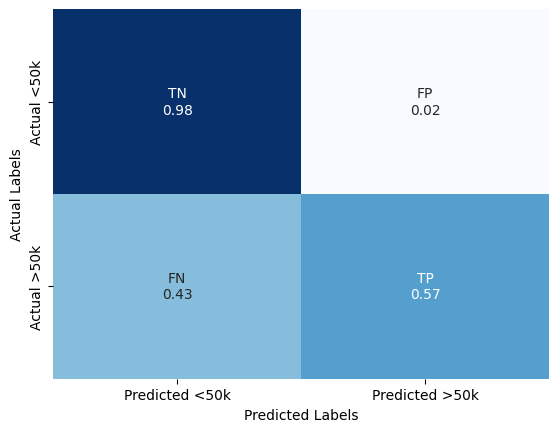

In [41]:
trainer_xgb.evaluate_model('xgb', X_test_xgb_t, y_test_xgb)

<b>Model Evaluation & Comparison:

<u>Precision:</u> LightGB shows the highest precision for predicting income > 50k, meaning fewer false positives compared to the other models

<u>Recall:</u> Logistic Regression captures more true positives, indicating it is better at identifying income > 50k, but at the expense of higher false positives

<u>F1 Score:</u> XGBoost and LightGB have balanced F1 Score, while Logistic Regression's F1 score is lower, showing the former two's balance of precsion and recall better

<u> ROC-AUC:</u> LightGB slightly outperforms XGBoost, and both outperform LR in distinguishing between the classes

<b>Confusion Matrix Insights

1. Logistic Regression has fewer false negatives but suffers from higher false positives
2. XGBoost and LightGB perform similarly in minimizing false positives, but XGBoost(57%) achieves better true positive rates than LightGB(51%)

<b>Recommendation:

<u>Best Recall Model: </u> Logistic Regression, to capture more cases of income >50k 

<u>Best Precision Model: </u> LightGBM, to reduce false positives

<u>Best Balanced Model: </u> XGBoost, with high F1 score and ROC-AUC despite LightGBM slightly edging out in performance 